# Projet 3 : Concevez une application au service de la santé publique
# Notebook 1

In [1]:
%%HTML
<a href="https://fr.openfoodfacts.org/" target="_blank"><img src=".\OpenFoodFacts.png" alt="Ce projet utilise les données d'Open Food Facts" />

<a id="sommaire"></a>
## Rappel de la mission et démarche utilisée
La mission de ce projet consiste à proposer une idée innovante d'application en lien avec l'alimentation et s'appuyant sur le jeu de données Open Food Facts.

Dans ce but, nous avons suivi la démarche ci-après.

**Partie 1 - Notebook de nettoyage - [Nettoyage pour filtrer les caractéristiques et des produits](#clean_fnp)**, afin d'acquérir la compréhension du jeu de donnée, d'en mesurer la teneur, de formuler en conséquence une idée d'application et de filtrer le jeu en fonction cette idée :
- [chargement et prise de connaissance du jeu de données](#ch_jeu) et examen du taux de remplissage ;
- [compréhension des caractéristiques et proposition de structuration](#struc_carac) pour faciliter la catégorisation des produits ;
- [premières constatations sur le jeu de données et sur ses possibilités et limitations d'exploitation](#consta) ;
- [formulation d'une idée d'application et identification en conséquence les caractéristiques à retenir](#idea_features) ;
- [filtrage du jeu de données](#filtrage) pour se concentrer sur les caractéristiques et données nécessaires à l'application ;
- [établissement du jeu de données filtré](#jeu_filtre)
- [suppression des doublons](#doublons).

**Partie 2 - Notebook de nettoyage - [Nettoyage pour identifier et traiter les valeurs aberrantes](#partie_2)** :
- [poser pour chaque caractéristique ce qui constitue une valeur aberrante](#def_outliers), en évitant les erreurs de filtrage (ex : filtrage du sel qui contient 100 g de sel pour 100 g de produit) ;
- [fixer le traitement des valeurs aberrantes](#clean_outliers), soit par suppression des produits correspondants, soit par remplacement de ces valeurs (NaN en attendant de les retraiter) ;
- [contrôles de cohérence au niveau du produit](#prod_level_check) (ex : la somme des composants pour 100 g) ;

**Partie 3 - Notebook de nettoyage - [Nettoyage pour traiter les valeurs manquantes](#partie_3)** :
- [Affectation directe de valeurs aux manquants](#miss_val_setting)
- [Estimation de valeurs manquantes](#miss_estimates)
- [Traitement des manquants restants](#miss_unknown) par affectation de la valeur '$***unknown***$'
- [conclusion](#conclusion) de ce notebook et sauvegarde du jeu de données tel que traité.

**Parties 4 et 5** : voir le Notebook d'analyse exploratoire


## Moyens utilisés
Ce projet est mené en langage Python, utilisant principalement les librairies Numpy, Pandas, Matplotlib et Seaborn.

Le rapport est constitué des fichiers suivants :
- Notebook de nettoyage : PSante_01_notebooknettoyage.ipynb
- Notebook d'analyse exploratoire : PSante_02_notebookanalyse.ipynb
- Présentation en support de la soutenance : PSante_03_presentation.pdf
- Fichier des fonctions Python utilisées par les notebooks : PSante_04_fonctions.py

L'étude est menée avec l'IDE Pycharm, Python 3.9.7 et des librairies spécifiées dans requirements.txt.


In [2]:
# Import des librairies et fonctions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PSante_04_fonctions as fct
import copy

# Dossier et fichier de données
dossierData = ".\PSante_05_data"
fichierData = "fr.openfoodfacts.org.products"

<a id="clean_fnp"></a>
## Partie 1 - Nettoyage pour filtrer les caractéristiques et des produits
<a id="ch_jeu"></a>
### Chargement et prise de connaissance du jeu de données
Le jeu de données est constitué d'une population de 320 772 individus (produits) et 162 variables.
L'examen des manquants (76%) montre un jeu de données globalement peu renseigné avec en particulier 16 variables pas du tout renseignées. En conséquence, le jeu est modifié pour éliminer ces 16 variables.
L'examen des variables montre que parmi les 146 variables, 56 sont catégorielles (type 'object') et 90 sont numériques (type 'float64'). En observant le type des 4 variables de temps, il apparait que certaines variables sont typées objet au lieu de numérique et il convient donc de détecter toutes celles qui ne sont pas du bon type, afin de les convertir.
Par ailleurs, nous avons besoin d'acquérir la compréhension de l'ensemble de ces variables afin de mieux appréhender le jeu de données et les possibilités qui s'offrent à nous en termes d'application.
Pour cela, nous avons besoin d'examiner chaque variable, nous assurer de son type et proposer une structuration afin d'en faciliter l'appréhension.

*[retour sommaire](#sommaire)*

In [3]:
# Chargement et prise de connaissance du jeu de données avec suppression du warning
print("Chargement du jeu de données, lecture avec encodage utf-8-sig\n")
data = pd.read_csv(dossierData + "\\" + fichierData + ".csv", sep='\t',
                   encoding='utf-8-sig', index_col=None, low_memory=False)
print("Dimension du jeu de données :", data.shape)

# Examen des manquants
dataMissing = pd.DataFrame([])
dataMissing['pc'] = 100.0 * data.isnull().sum(axis=0) / data.shape[0]
dataMissing['nb'] = data.isnull().sum(axis=0)
print("Manquants total:",
      '{:0.0f}%'.format((100.0 * dataMissing['nb'].sum(axis=0)) / (data.shape[0] * data.shape[1]), "%\n"))
print("Manquants par variable:\n")
with pd.option_context('display.float_format', '{:0.0f}%'.format):
    display(dataMissing)

# Elimination des variables n'ayant aucune valeur (colonnes vides)
print("Elimination des variables n'ayant aucune valeur (colonnes vides)")
# Identification et suppression des colonnes à supprimer
dropCol = dataMissing.loc[dataMissing['nb'] >= data.shape[0]]
print("Suppression de", dropCol.shape[0], "colonnes :", ', '.join(dropCol.index.tolist()), '\n')
#print(dropCol.index.tolist(), '\n')
data.drop(labels=dropCol.index.tolist(), axis=1, inplace=True)
print("Nouvelle dimension du jeu de données:", data.shape, '\n')

# Affichage du type de chaque variable
print(data.dtypes, '\n')

# Récupération des variables conservées pour travailler leur structuration et vérifier leur type
dataMissing = dataMissing.loc[dataMissing['nb'] < data.shape[0]]
print("Liste des variables à examiner: \n", ', '.join(dataMissing.index.values.tolist()))
#fct.writeDF2XLfile(dataMissing, dossierData + "\\" + fichierData + "_missings")

Chargement du jeu de données, lecture avec encodage utf-8-sig

Dimension du jeu de données : (320772, 162)
Manquants total: 76%
Manquants par variable:



,pc,nb
code,0%,23
url,0%,23
creator,0%,2
created_t,0%,3
created_datetime,0%,9
last_modified_t,0%,0
last_modified_datetime,0%,0
product_name,6%,17762
generic_name,84%,267977
quantity,67%,215953


Elimination des variables n'ayant aucune valeur (colonnes vides)
Suppression de 16 colonnes : no_nutriments, ingredients_from_palm_oil, ingredients_that_may_be_from_palm_oil, nutrition_grade_uk, butyric-acid_100g, caproic-acid_100g, lignoceric-acid_100g, cerotic-acid_100g, melissic-acid_100g, elaidic-acid_100g, mead-acid_100g, erucic-acid_100g, nervonic-acid_100g, chlorophyl_100g, glycemic-index_100g, water-hardness_100g 

Nouvelle dimension du jeu de données: (320772, 146) 

code                                           object
url                                            object
creator                                        object
created_t                                      object
created_datetime                               object
last_modified_t                                object
last_modified_datetime                         object
product_name                                   object
generic_name                                   object
quantity                         

<a id="struc_carac"></a>
### Compréhension des caractéristiques et proposition de structuration
Examen des variables qui pourraient être numériques et modification le cas échéant :
- Variables de temps de forme '_t' : ces 2 variables sont converties au format numérique.
- Autres variables de temps : ces variables sont converties au format datetime64 et les erreurs de format de ces 2 variables sont mises à NaT.
- Variables 'quantity' et 'serving_size' : ces variables sont renseignées avec une grande diversité d'unités de mesure ne les rendant pas convertissable en numérique, nous les conserverons donc en format objet.
- Variable 'first_packaging_code_geo' : cette variable peu renseignée se présente sous la forme de deux décimaux séparés par une virgule (coordonnées GPS), que nous conserverons sous cette forme pour le moment ; en cas de besoin, nous séparerons ces données sur 2 colonnes numériques.

Proposition de structuration des variables : le dataframe présente une structuration à 3 niveaux regroupant les variables par famille et sous-famille et précisant le type (numérique ou catégorielle) de chacune.

*[retour sommaire](#sommaire)*

In [4]:
# Transformation des variables de temps de type "_t" en numérique
print("Conversion en numérique des variables de temps de type '_t':")
numCol = [3, 5]
for col in numCol:
    data[data.columns[col]] = pd.to_numeric(data[data.columns[col]], errors='coerce')
    print("- Colonne n°", col, ",", data.columns.tolist()[col], ":", data[data.columns[col]].dtypes)

# Autres variables de temps
print("\nVérification du format des variables de temps :")
data['created_datetime'] = pd.to_datetime(data['created_datetime'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
mask = data['created_datetime'].isnull()
print("- Variable 'created_datetime':", mask.sum(), "erreurs de formatage de temps aux index :",
      ', '.join(map(str, data.loc[mask, 'created_datetime'].index.tolist())))
print("  --> Nouveau type :", data['created_datetime'].dtypes)

data['last_modified_datetime'] = pd.to_datetime(data['last_modified_datetime'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
mask = data['last_modified_datetime'].isnull()
print("- Variable 'last_modified_datetime':", mask.sum(), "erreurs de formatage de temps aux index :",
      ', '.join(map(str, data.loc[mask, 'last_modified_datetime'].index.tolist())))
print("  --> Nouveau type :", data['last_modified_datetime'].dtypes, '\n')

# Examen de la variable "quantity"
fct.listCategories(data, 'quantity', sort_by='size', nRows=10)

# Examen de la variable "serving_size"
fct.listCategories(data, 'serving_size', sort_by='size', nRows=10)

# Examen de la variable "first_packaging_code_geo"
fct.listCategories(data, 'first_packaging_code_geo', sort_by='size', nRows=10)

# Proposition de structuration des variables
fichierFeatures = "fr.openfoodfacts.org.products_proposed_structure"
features = pd.read_csv(dossierData + "\\" + fichierFeatures + ".csv", sep=';', index_col=None)
print("Structuration des variables :")
display(features)

Conversion en numérique des variables de temps de type '_t':
- Colonne n° 3 , created_t : float64
- Colonne n° 5 , last_modified_t : float64

Vérification du format des variables de temps :
- Variable 'created_datetime': 24 erreurs de formatage de temps aux index : 187478, 189068, 189103, 189109, 189119, 189152, 189160, 189162, 189168, 189242, 189244, 189248, 189250, 189260, 189262, 189269, 189272, 189345, 189362, 189364, 189379, 189404, 189406, 189417
  --> Nouveau type : datetime64[ns, UTC]
- Variable 'last_modified_datetime': 23 erreurs de formatage de temps aux index : 189068, 189103, 189109, 189119, 189152, 189160, 189162, 189168, 189242, 189244, 189248, 189250, 189260, 189262, 189269, 189272, 189345, 189362, 189364, 189379, 189404, 189406, 189417
  --> Nouveau type : datetime64[ns, UTC] 

Liste des catégories de 'quantity' ('size' indique le nombre d'occurrences) :


,index,quantity,size
0,10205,500 g,4669
1,4815,200 g,4063
2,5833,250 g,3883
3,1698,100 g,3043
4,8848,400 g,2523
5,7019,300 g,2452
6,3070,150 g,2303
7,941,1 l,1636
8,872,1 kg,1592
9,2484,125 g,1503


--> 104819 éléments sur 320772 soit 32.68% 

Liste des catégories de 'serving_size' ('size' indique le nombre d'occurrences) :


,index,serving_size,size
0,9730,240 ml (8 fl oz),5496
1,11169,28 g (1 oz),5374
2,11069,28 g (1 ONZ),3770
3,5859,15 ml (1 Tbsp),2959
4,13037,30 g (2 Tbsp),2899
5,12701,30 g,2587
6,12744,30 g (0.25 cup),2119
7,9697,240 ml (1 cup),2012
8,4874,14 g (1 Tbsp),1885
9,13442,30 ml (2 Tbsp),1754


--> 211331 éléments sur 320772 soit 65.88% 

Liste des catégories de 'first_packaging_code_geo' ('size' indique le nombre d'occurrences) :


,index,first_packaging_code_geo,size
0,854,"47.633333,-2.666667",279
1,905,"47.833333,-0.333333",245
2,1406,"49.266667,-0.666667",197
3,1035,"48.1,-4.333333",169
4,650,"46.698333,-1.939444",164
5,956,"47.933333,-4.016667",162
6,641,"46.666667,-0.85",148
7,924,"47.866667,2.116667",142
8,667,"46.783333,-0.833333",140
9,984,"48,-4.1",129


--> 18803 éléments sur 320772 soit 5.86% 

Structuration des variables :


,structure_n1,structure_n2,variables,manquants_pc,manquants_nb,type_quantitative,type_categorielle
0,composition,additives,additives_n,22.39%,71833,1.0,NaN
1,composition,additives,additives,22.40%,71867,NaN,1.0
2,composition,additives,additives_tags,51.78%,166092,NaN,1.0
3,composition,additives,additives_fr,51.78%,166092,NaN,1.0
4,composition,allergens,allergens,91.16%,292428,NaN,1.0
5,composition,allergens,allergens_fr,99.99%,320753,NaN,1.0
6,composition,palm_oil,ingredients_from_palm_oil_n,22.39%,71833,1.0,NaN
7,composition,palm_oil,ingredients_from_palm_oil_tags,98.49%,315937,NaN,1.0
8,composition,palm_oil,ingredients_that_may_be_from_palm_oil_n,22.39%,71833,1.0,NaN
9,composition,palm_oil,ingredients_that_may_be_from_palm_oil_tags,96.35%,309076,NaN,1.0


<a id="consta"></a>
### Premières constatations sur le jeu de données et sur ses possibilités et limitations d'exploitation
L'examen de cette structuration de variables, en fonction du nombre de manquants, montre que certaines familles de variables sont suffisamment renseignées pour envisager leur exploitation par une application :
- Moins de 10% de manquants : 'dates', 'keys', 'status', 'sale_location', 'product', et 'brand'.
- De 10% à 30% de manquants : 'product_intake' ('energy', 'protein', 'salt', 'carbohydrates', 'fats') et 'composition' ('ingredients_text', et les nombres concernant : 'additives' et 'palm_oil').
- De 30% à 40% de manquants : 'nutrition_quality'.

Par ailleurs, la famille 'product_intake' contient de nombreuses variable très peu renseignées, mais cela peut résulter de leur faible présence dans la majorité des produits. Il en va de même pour les variables 'composition' concernant 'allergens', 'traces' et 'palm_oil'.

Avec plus de 88% de manquant, la famille de variable 'traceability' sera difficilement exploitable.

Enfin, la famille 'product_category' comporte de 70% à 75% de manquant pour 7 de ses variables, et 83.5% pour la 8$^{ème}$. Cette information semble particulièrement utile dans la conception d'une application et nous devrons examiner si nous pouvons combiner les informations de ses variables pour couvrir davantage de produits.

*[retour sommaire](#sommaire)*

<a id="idea_features"></a>
### Formulation d'une idée d'application et identification en conséquence les caractéristiques à retenir

1) L'utilisation de l'application est envisagée sur la base des produits disponibles en France.

2) L'utilisateur entre une demande combinant :
   - les types d'apport nutritionnel à contenir concernant les vitamines et sels minéraux ;
   - les types d'apport nutritionnel à minimiser concernant le sel, le sucres, les graisses saturées ou les graisses trans ;
   - d'éventuels éléments à exclure en termes d'allergènes, d'huile de palme, et d'additifs.

3) L'application propose en retour une liste des meilleurs produits classés selon leur qualité en termes de score nutritionnel.

4) À partir d'un produit de la liste, l'utilisateur a la possibilité d'élargir sa recherche à d’autres produits en fonction de la catégorie.

À partir de cette idée, nous vérifions tout d'abord la teneur du jeu de données pour les produits vendus en France puis le réduisons en conséquence : avec 98440 individus, le nombre de produits disponibles en France est suffisant et nous procédons dans ce sens.

*[retour sommaire](#sommaire)*

In [5]:
# Examen des variables de la famille 'sale_location'
# Variable 'countries'
categories = fct.listCategories(data, 'countries', 'ret', sort_by='size', nRows=5)
nb_pdt = categories.loc[categories['countries'].str.contains("France", case=False)]['size'].sum()
print("La variable 'countries' comptabilise", nb_pdt, "produits vendus au moins en France", '\n')

# Variable 'countries_tags'
categories = fct.listCategories(data, 'countries_tags', 'ret', sort_by='size', nRows=5)
nb_pdt = categories.loc[categories['countries_tags'].str.contains("France", case=False)]['size'].sum()
print("La variable 'countries_tags' comptabilise", nb_pdt, "produits vendus au moins en France", '\n')

# Variable 'countries_fr'
categories = fct.listCategories(data, 'countries_fr', 'ret', sort_by='size', nRows=5)
nb_pdt = categories.loc[categories['countries_fr'].str.contains("France", case=False)]['size'].sum()
print("La variable 'countries_fr' comptabilise:", nb_pdt, "produits vendus au moins en France", '\n')

# Filtrage du jeu de données pour ne retenir que les produits vendus en France
mask = ~data['countries_fr'].str.contains("France", case=False, na=False)
data.loc[mask, 'countries_fr'] = np.nan
data.dropna(subset='countries_fr', inplace=True)
print("Taille du nouveau jeu de données :", data.shape, '\n')
display(data.head())

# Suppression des variables 'countries', 'countries_tags' et 'country_fr' du jeu de données
data.drop(['countries', 'countries_tags', 'countries_fr'], axis=1, inplace=True)

Liste des catégories de 'countries' ('size' indique le nombre d'occurrences) :


,index,countries,size
0,1049,US,169928
1,404,France,77292
2,1185,en:FR,16979
3,986,Suisse,12314
4,317,Deutschland,6161


--> 320492 éléments sur 320772 soit 99.91% 

La variable 'countries' comptabilise 80865 produits vendus au moins en France 

Liste des catégories de 'countries_tags' ('size' indique le nombre d'occurrences) :


,index,countries_tags,size
0,693,en:united-states,172998
1,327,en:france,94391
2,657,en:switzerland,14953
3,475,en:germany,7870
4,649,en:spain,5009


--> 320492 éléments sur 320772 soit 99.91% 

La variable 'countries_tags' comptabilise 98440 produits vendus au moins en France 

Liste des catégories de 'countries_fr' ('size' indique le nombre d'occurrences) :


,index,countries_fr,size
0,708,États-Unis,172998
1,327,France,94392
2,636,Suisse,14953
3,13,Allemagne,7870
4,312,Espagne,5009


--> 320492 éléments sur 320772 soit 99.91% 

La variable 'countries_fr' comptabilise: 98440 produits vendus au moins en France 

Taille du nouveau jeu de données : (98440, 146) 



,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,packaging,packaging_tags,brands,brands_tags,categories,categories_tags,categories_fr,origins,origins_tags,manufacturing_places,manufacturing_places_tags,labels,labels_tags,labels_fr,emb_codes,emb_codes_tags,first_packaging_code_geo,cities,cities_tags,purchase_places,stores,countries,countries_tags,countries_fr,ingredients_text,allergens,allergens_fr,traces,traces_tags,traces_fr,serving_size,additives_n,additives,additives_tags,additives_fr,ingredients_from_palm_oil_n,ingredients_from_palm_oil_tags,ingredients_that_may_be_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_tags,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,states,states_tags,states_fr,main_category,main_category_fr,image_url,image_small_url,energy_100g,energy-from-fat_100g,fat_100g,saturated-fat_100g,caprylic-acid_100g,capric-acid_100g,lauric-acid_100g,myristic-acid_100g,palmitic-acid_100g,stearic-acid_100g,arachidic-acid_100g,behenic-acid_100g,montanic-acid_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,omega-3-fat_100g,alpha-linolenic-acid_100g,eicosapentaenoic-acid_100g,docosahexaenoic-acid_100g,omega-6-fat_100g,linoleic-acid_100g,arachidonic-acid_100g,gamma-linolenic-acid_100g,dihomo-gamma-linolenic-acid_100g,omega-9-fat_100g,oleic-acid_100g,gondoic-acid_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,sucrose_100g,glucose_100g,fructose_100g,lactose_100g,maltose_100g,maltodextrins_100g,starch_100g,polyols_100g,fiber_100g,proteins_100g,casein_100g,serum-proteins_100g,nucleotides_100g,salt_100g,sodium_100g,alcohol_100g,vitamin-a_100g,beta-carotene_100g,vitamin-d_100g,vitamin-e_100g,vitamin-k_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,vitamin-b6_100g,vitamin-b9_100g,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
0,0000000003087,http://world-fr.openfoodfacts.org/produit/0000000003087/farine-de-ble-noir-ferme-t-y-r-nao,openfoodfacts-contributors,1.474e+09,2016-09-17 09:17:46+00:00,1.474e+09,2016-09-17 09:18:13+00:00,Farine de blé noir,NaN,1kg,NaN,NaN,Ferme t'y R'nao,ferme-t-y-r-nao,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en:FR,en:france,France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"en:to-be-completed, en:nutrition-facts-to-be-completed, en:ingredients-to-be-completed, en:expiration-date-to-be-completed, en:characteristics-to-be-completed, en:categories-to-be-completed, en:b...","en:to-be-completed,en:nutrition-facts-to-be-completed,en:ingredients-to-be-completed,en:expiration-date-to-be-completed,en:characteristics-to-be-completed,en:categories-to-be-completed,en:brands-...","A compléter,Informations nutritionnelles à compléter,Ingrédients à compléter,Date limite à compléter,Caractéristiques à compléter,Catégories à compléter,Marques complétées,Emballage à compléter,Q...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46,0000000024600,http://world-fr.openfoodfacts.org/produit/0000000024600/filet-de-boeuf,date-limite-app,1.435e+09,2015-06-17 08:45:04+00:00,1.435e+09,2015-06-17 10:11:54+00:00,Filet de bœuf,NaN,2.46 kg,plastique,plastique,NaN,NaN,Filet de bœuf,fr:filet-de-boeuf,Filet-de-boeuf,NaN,NaN,NaN,NaN,NaN,NaN,N

<a id="filtrage"></a>
### Filtrage du jeu de données
À partir de ce jeu adapté à la France, nous allons examiner les variables et combinaisons de variables les plus appropriées et renseignées sur lesquelles s'appuyer pour l'application envisagée.
- Famille '<font color='green'>products</font>' :
  - Variables '<font color='green'>brands</font>' : conservation du meilleur des 2 variables en conservant la valeur de 'brands' lorsqu'elle existe et supprimant les valeurs identifiées comme NaN ; colonne résultante nommée '<font color='green'>brands</font>'.
  - Variables '<font color='green'>keys</font>' : nous ne conservons que la variable '<font color='green'>url</font>'.
  - Variables '<font color='green'>product</font>' : nous conservons que la variable '<font color='green'>product_name</font>' ('image_url' est couvert par 'url').
  - Variables '<font color='green'>sale_location</font>' : nous conservons la variable '<font color='green'>stores</font>', plus utile que 'purchase_places' (les variables pays ne sont pas conservées puisque nous nous limitons à la France).
- Famille '<font color='green'>composition</font>':
  - Variables '<font color='green'>additives</font>' : conservation des variables '<font color='green'>additives_n</font>' et '<font color='green'>additives_tags</font>', cette dernière plus explicite que 'additives_fr'.
  - Variables '<font color='green'>allergens</font>' : conservation de '<font color='green'>allergens</font>' (l'autre n'est pas renseignée) ; à noter le fait que des éléments sont souvent répétés dans la même valeur et que cette liste pourrait être nettoyée plus avant.
  - Variables '<font color='green'>...palm_oil...</font>' : nous ne conservons que les variables quantitatives 'ingredients_from_palm_oil_n' et 'ingredients_that_may_be_from_palm_oil_n', que nous regroupons dans une colonne '<font color='green'>palm</font>' indiquant si le produit contient ou pourrait contenir de l'huile de palme sous forme d'un booléen en conservant les NaN (équivalent à 3 valeurs: 'oui', 'non' et 'ne sait pas').
  - Variables '<font color='green'>traces</font>' : nous ne conservons pas ces variables.
- Famille '<font color='green'>product_category</font>' : nous conservons pour le moment les variables '<font color='green'>pnns_groups_1</font>' et '<font color='green'>pnns_groups_2</font>'. Nous pourrions revenir sur ce choix en fonction de l'expérience utilisateur.
- Famille '<font color='green'>product_intake</font>' :
  - S'agissant des types d'apport nutritionnel à maximiser, nous conservons pour le moment les variables des familles '<font color='green'>vitamins</font>' et '<font color='green'>minerals</font>'.
  - S'agissant des types d'apport nutritionnel à minimiser, nous sélectionnons quelques variables clés parmi les variables des familles 'salt', 'fats' et 'carbohydrates' : '<font color='green'>salt_100g</font>' (donne la même indication que 'sodium_100g' avec un facteur de 2.5), '<font color='green'>saturated-fat_100g</font>', '<font color='green'>trans-fat_100g</font>', et '<font color='green'>sugars_100g</font>'.
- Famille '<font color='green'>quality</font>' : nous conservons les variables '<font color='green'>nutrition_grade_fr</font>' et '<font color='green'>nutrition-score-fr_100g</font>' (équivalent à la variable 'nutrition-score-uk_100g') ; en particulier, nous ne conservons pas les 3 variables de label.

Familles de variables non conservées: '<font color='green'>dates</font>', '<font color='green'>packaging</font>', '<font color='green'>quantity</font>', '<font color='green'>status</font>' et '<font color='green'>traceability</font>'.

*[retour sommaire](#sommaire)*

In [6]:
# Examen des variables de la famille 'brands'
fct.listCategories(data, 'brands', sort_by='size')
fct.listCategories(data, 'brands_tags', sort_by='size')
mergeCol = fct.mergeCol(data, 'brands', 'brands_tags', method='best')
# On conserve 'brands' en mettant à NaN les valeurs identifiées non explicites
mask = data[mergeCol].isin(['??', '--', '.', '?'])
data.loc[mask, mergeCol] = np.NaN
data.drop(['brands_tags', 'brands'], axis=1, inplace=True)
data.rename(columns={mergeCol : 'brands'}, inplace=True)

Liste des catégories de 'brands' ('size' indique le nombre d'occurrences) :


,index,brands,size
0,2692,Carrefour,2837
1,827,Auchan,2303
2,18212,U,2039
3,10013,Leader Price,1684
4,2868,Casino,1596
5,3859,Cora,984
6,14288,Picard,902
7,12474,Monoprix,751
8,4637,Dia,538
9,5927,Fleury Michon,520


--> 86426 éléments sur 98440 soit 87.80% 

Liste des catégories de 'brands_tags' ('size' indique le nombre d'occurrences) :


,index,brands_tags,size
0,2261,carrefour,2976
1,671,auchan,2430
2,15294,u,2071
3,8394,leader-price,1873
4,2379,casino,1681
5,3287,cora,1009
6,11986,picard,958
7,10460,monoprix,781
8,5041,fleury-michon,562
9,3925,dia,557


--> 86422 éléments sur 98440 soit 87.79% 

* Comparaison des colonnes brands et brands_tags comprenant 98440 lignes
  La colonne brands contient 86426 valeurs et la colonne brands_tags 86422 valeurs
  -> La fusion des 2 colonnes à partir de brands apporte 2 valeurs supplémentaires 



,brands,brands_tags
248232,NaN,na
248234,NaN,na
191673,??,NaN
214446,--,NaN
234219,.,NaN
251895,?,NaN
304555,?,NaN
306163,?,NaN


In [7]:
# Examen des variables 'composition' / 'additives'
fct.listCategories(data, 'additives', sort_by='size')
fct.listCategories(data, 'additives_tags', sort_by='size')
data.drop(['additives'], axis=1, inplace=True)

Liste des catégories de 'additives' ('size' indique le nombre d'occurrences) :


,index,additives,size
0,37602,[ semoule-de-ble-dur-de-qualite-superieure -> fr:semoule-de-ble-dur-de-qualite-superieure ] [ semoule-de-ble-dur-de-qualite -> fr:semoule-de-ble-dur-de-qualite ] [ semoule-de-ble-dur-de -> f...,197
1,356,[ 100-semoule-de-ble-dur-de-qualite-superieure -> fr:100-semoule-de-ble-dur-de-qualite-superieure ] [ 100-semoule-de-ble-dur-de-qualite -> fr:100-semoule-de-ble-dur-de-qualite ] [ 100-semoul...,149
2,21731,[ jus-d-orange -> fr:jus-d-orange ] [ jus-d -> fr:jus-d ] [ jus -> fr:jus ],87
3,5732,[ contient-des-sulfites -> fr:contient-des-sulfites ] [ contient-des -> fr:contient-des ] [ contient -> fr:contient ],78
4,10740,[ eau-minerale-naturelle -> fr:eau-minerale-naturelle ] [ eau-minerale -> fr:eau-minerale ] [ eau -> fr:eau ],66
5,37466,[ semoule-de-ble-dur -> fr:semoule-de-ble-dur ] [ semoule-de-ble -> fr:semoule-de-ble ] [ semoule-de -> fr:semoule-de ] [ semoule -> fr:semoule ] [ eau -> fr:eau ],63
6,37448,[ semoule-de-ble-dur -> fr:semoule-de-ble-dur ] [ semoule-de-ble -> fr:semoule-de-ble ] [ semoule-de -> fr:semoule-de ] [ semoule -> fr:semoule ],60
7,19724,[ haricots-verts -> fr:haricots-verts ] [ haricots -> fr:haricots ] [ eau -> fr:eau ] [ sel -> fr:sel ],57
8,44852,[ vin -> fr:vin ] [ sulfites -> fr:sulfites ],55
9,23946,[ lait-demi-ecreme-sterilise-uht -> fr:lait-demi-ecreme-sterilise-uht ] [ lait-demi-ecreme-sterilise -> fr:lait-demi-ecreme-sterilise ] [ lait-demi-ecreme -> fr:lait-demi-ecreme ] [ lait-d...,52


--> 53453 éléments sur 98440 soit 54.30% 

Liste des catégories de 'additives_tags' ('size' indique le nombre d'occurrences) :


,index,additives_tags,size
0,3614,en:e322,1714
1,4905,en:e330,1175
2,3106,en:e300,1093
3,8165,en:e440,470
4,3364,"en:e301,en:e250",392
5,2401,en:e250,362
6,404,en:e14xx,317
7,5411,"en:e330,en:e300",302
8,1680,en:e160c,270
9,8218,"en:e440,en:e330",262


--> 30456 éléments sur 98440 soit 30.94% 



In [8]:
# Examen des variables 'composition' / 'allergens'
fct.listCategories(data, 'allergens', sort_by='size')
fct.listCategories(data, 'allergens_fr', sort_by='size')
data.drop(['allergens_fr'], axis=1, inplace=True)

Liste des catégories de 'allergens' ('size' indique le nombre d'occurrences) :


,index,allergens,size
0,2545,blé,1266
1,999,Lait,810
2,7013,lait,690
3,9496,sulfites,395
4,9241,soja,355
5,6052,céleri,272
6,1242,"Lait, lait",271
7,8838,orge,242
8,6886,lactose,229
9,3026,"blé, blé",218


--> 22904 éléments sur 98440 soit 23.27% 

Liste des catégories de 'allergens_fr' ('size' indique le nombre d'occurrences) :


,index,allergens_fr,size


--> 0 éléments sur 98440 soit 0.00% 



In [9]:
# Tri des features par nombre croissant de manquants
display(features.sort_values(by='manquants_nb'))

,structure_n1,structure_n2,variables,manquants_pc,manquants_nb,type_quantitative,type_categorielle
18,dates,NaN,last_modified_datetime,0.00%,0,1.0,NaN
14,dates,NaN,creator,0.00%,2,NaN,1.0
16,dates,NaN,created_datetime,0.00%,9,1.0,NaN
117,products,keys,url,0.01%,23,NaN,1.0
17,dates,NaN,last_modified_t,0.01%,23,1.0,NaN
116,products,keys,code,0.01%,23,NaN,1.0
15,dates,NaN,created_t,0.01%,23,1.0,NaN
134,status,NaN,states,0.01%,46,NaN,1.0
135,status,NaN,states_tags,0.01%,46,NaN,1.0
136,status,NaN,states_fr,0.01%,46,NaN,1.0


In [10]:
# Examen des variables 'composition' / 'palm_oil'
data.drop(['ingredients_that_may_be_from_palm_oil_tags'], axis=1, inplace=True)
data.drop(['ingredients_from_palm_oil_tags'], axis=1, inplace=True)
# Remplace la variable 'ingredients_from_palm_oil_n' par un booléen qui conserve les NaN
mask1 = data['ingredients_from_palm_oil_n'].isnull()
data['ingredients_from_palm_oil_n'] = ~(data['ingredients_from_palm_oil_n'] == 0)
data.loc[mask1, 'ingredients_from_palm_oil_n'] = np.NaN
# Remplace la variable 'ingredients_that_may_be_from_palm_oil_n' par un booléen qui conserve les NaN
mask2 = data['ingredients_that_may_be_from_palm_oil_n'].isnull()
data['ingredients_that_may_be_from_palm_oil_n'] = ~(data['ingredients_that_may_be_from_palm_oil_n'] == 0)
data.loc[mask2, 'ingredients_that_may_be_from_palm_oil_n'] = np.NaN
# Nouvelle colonne 'palm' conservant les NaN pour déterminer si un produit contient ou peut contenir de l'huile de palme
data['palm'] = np.logical_or(data['ingredients_from_palm_oil_n'], data['ingredients_that_may_be_from_palm_oil_n'])
# Elimination des colonnes désormais inutiles
data.drop(['ingredients_from_palm_oil_n'], axis=1, inplace=True)
data.drop(['ingredients_that_may_be_from_palm_oil_n'], axis=1, inplace=True)

In [11]:
# Examen des variables 'dates', 'keys', 'packaging' et 'product'
data.drop(['last_modified_datetime'], axis=1, inplace=True)
data.drop(['creator'], axis=1, inplace=True)
data.drop(['created_datetime'], axis=1, inplace=True)
data.drop(['created_t'], axis=1, inplace=True)
data.drop(['packaging_tags'], axis=1, inplace=True)
data.drop(['packaging'], axis=1, inplace=True)
data.drop(['image_small_url'], axis=1, inplace=True)

In [12]:
# Examen des variables 'product_category'
# Prise de connaissance et nettoyage de 'pnns_groups_1'
fct.listCategories(data, 'pnns_groups_1', nRows=100)
fct.changeValues(data, 'pnns_groups_1', np.NaN, ['unknown'])
fct.changeValues(data, 'pnns_groups_1', 'Fruits and vegetables', ['fruits-and-vegetables'])
fct.changeValues(data, 'pnns_groups_1', 'Sugary snacks', ['sugary-snacks'])
fct.changeValues(data, 'pnns_groups_1', 'Cereals and potatoes', ['cereals-and-potatoes'])
fct.listCategories(data, 'pnns_groups_1', sort_by='size', nRows=100)
# Prise de connaissance et nettoyage de 'pnns_groups_2'
fct.listCategories(data, 'pnns_groups_2', nRows=100)
fct.changeValues(data, 'pnns_groups_2', np.NaN, ['unknown'])
fct.changeValues(data, 'pnns_groups_2', 'Cereals', ['cereals'])
fct.changeValues(data, 'pnns_groups_2', 'Fruits', ['fruits'])
fct.changeValues(data, 'pnns_groups_2', 'Vegetables', ['vegetables', 'Legumes', 'legumes'])
fct.listCategories(data, 'pnns_groups_2', sort_by='size', nRows=100)
# Examen de la complémentarité de 'pnns_groups_1' et 'pnns_groups_2'
mergeCol = fct.mergeCol(data, 'pnns_groups_1', 'pnns_groups_2', method='concat')
fct.listCategories(data, mergeCol, nRows=100)

Liste des catégories de 'pnns_groups_1' ('size' indique le nombre d'occurrences) :


,pnns_groups_1,size
0,Beverages,6597
1,Cereals and potatoes,6128
2,Composite foods,6046
3,Fat and sauces,3794
4,Fish Meat Eggs,6768
5,Fruits and vegetables,4077
6,Milk and dairy products,6421
7,Salty snacks,2122
8,Sugary snacks,9407
9,cereals-and-potatoes,2


--> 64881 éléments sur 98440 soit 65.91% 

Liste des catégories de 'pnns_groups_1' ('size' indique le nombre d'occurrences) :


,index,pnns_groups_1,size
0,8,Sugary snacks,9879
1,4,Fish Meat Eggs,6768
2,0,Beverages,6597
3,6,Milk and dairy products,6421
4,1,Cereals and potatoes,6130
5,2,Composite foods,6046
6,5,Fruits and vegetables,4626
7,3,Fat and sauces,3794
8,7,Salty snacks,2122


--> 52383 éléments sur 98440 soit 53.21% 

Liste des catégories de 'pnns_groups_2' ('size' indique le nombre d'occurrences) :


,pnns_groups_2,size
0,Alcoholic beverages,2092
1,Appetizers,1627
2,Artificially sweetened beverages,211
3,Biscuits and cakes,3764
4,Bread,1321
5,Breakfast cereals,1111
6,Cereals,3045
7,Cheese,3026
8,Chocolate products,2216
9,Dairy desserts,747


--> 67038 éléments sur 98440 soit 68.10% 

Liste des catégories de 'pnns_groups_2' ('size' indique le nombre d'occurrences) :


,index,pnns_groups_2,size
0,23,One-dish meals,4946
1,3,Biscuits and cakes,3764
2,31,Sweets,3427
3,6,Cereals,3046
4,7,Cheese,3026
5,26,Processed meat,2905
6,21,Non-sugared beverages,2885
7,33,Vegetables,2844
8,10,Dressings and sauces,2610
9,8,Chocolate products,2216


--> 54540 éléments sur 98440 soit 55.40% 

* Fusion par concaténation des valeurs des colonnes pnns_groups_1 et pnns_groups_2
Liste des catégories de 'pnns_groups_1_pnns_groups_2' ('size' indique le nombre d'occurrences) :


,pnns_groups_1_pnns_groups_2,size
0,Beverages; Artificially sweetened beverages,211
1,Beverages; Fruit juices,1531
2,Beverages; Fruit nectars,310
3,Beverages; Non-sugared beverages,2885
4,Beverages; Sweetened beverages,1660
5,Cereals and potatoes; Bread,1321
6,Cereals and potatoes; Breakfast cereals,1111
7,Cereals and potatoes; Cereals,3046
8,Cereals and potatoes; Potatoes,104
9,Cereals and potatoes; Vegetables,548


--> 52383 éléments sur 98440 soit 53.21% 



L'examen des 4 variables ci-après de la famille 'product_category' montre une évolution progressive des catégories de produit, du plus général 'pnns_group1' vers 'generic_name' :
- 'pnns_group1' :   9 catégories
- 'pnns_group2' :   35 catégories
- 'categories_fr' : 15640 catégories
- 'generic_name' :  27340 catégories

Nous faisons ici le choix de ne conserver que les variables 'pnns_group1' et 'pnns_group2' pour l'application. En fonction de l'expérience utilisateur, nous pourrions revenir sur ce choix.

*[retour sommaire](#sommaire)*

In [13]:
# Examen des variables 'categories*'
fct.listCategories(data, 'categories', sort_by='size', nRows=100)
nbCat = fct.listCategories(data, 'categories_fr', 'ret', sort_by='size', nRows=100).shape[0]
print("Nombre de catégories de 'categories_fr' :", nbCat, '\n')
fct.listCategories(data, 'categories_tags', sort_by='size', nRows=100)
mergeCol = fct.mergeCol(data, 'categories_fr', 'categories', method='concat')
fct.listCategories(data, mergeCol, sort_by='size', nRows=100)
data.drop(['categories_tags'], axis=1, inplace=True)
data.drop(['categories'], axis=1, inplace=True)
data.drop([mergeCol], axis=1, inplace=True)

nbCat = fct.listCategories(data, 'generic_name', 'ret', sort_by='size', nRows=100).shape[0]
print("Nombre de catégories de 'generic_name' :", nbCat)

Liste des catégories de 'categories' ('size' indique le nombre d'occurrences) :


,index,categories,size
0,20383,"Snacks sucrés,Biscuits et gâteaux,Biscuits",291
1,20395,"Snacks sucrés,Biscuits et gâteaux,Biscuits,Biscuits au chocolat",242
2,3815,Biscuits,222
3,20803,"Snacks sucrés,Chocolats,Chocolats noirs",209
4,23224,"Viandes,Charcuteries,Jambons,Jambons blancs",207
5,2429,"Aliments et boissons à base de végétaux,Aliments d'origine végétale,Petit-déjeuners,Céréales et pommes de terre,Céréales et dérivés,Céréales pour petit-déjeuner",207
6,5653,Bonbons,184
7,20725,"Snacks sucrés,Chocolats,Chocolats au lait",176
8,5675,Bonbons gélifiés,167
9,6581,Chocolats noirs,162


--> 61955 éléments sur 98440 soit 62.94% 

Liste des catégories de 'categories_fr' ('size' indique le nombre d'occurrences) :


,index,categories_fr,size
0,12289,"Snacks sucrés,Biscuits et gâteaux,Biscuits",580
1,12301,"Snacks sucrés,Biscuits et gâteaux,Biscuits,Biscuits au chocolat",440
2,3019,"Aliments et boissons à base de végétaux,Aliments d'origine végétale,Petit-déjeuners,Céréales et pommes de terre,Céréales et dérivés,Céréales pour petit-déjeuner",428
3,13033,"Snacks sucrés,Chocolats,Chocolats noirs",427
4,13140,"Snacks sucrés,Confiseries,Bonbons",384
5,12121,"Snacks salés,Apéritif,Biscuits apéritifs",349
6,12948,"Snacks sucrés,Chocolats,Chocolats au lait",320
7,14335,"Viandes,Charcuteries,Jambons,Jambons blancs",316
8,13198,"Snacks sucrés,Confiseries,Bonbons,Bonbons gélifiés",245
9,6838,"Epicerie,Sauces",239


--> 61955 éléments sur 98440 soit 62.94% 

Nombre de catégories de 'categories_fr' : 15640 

Liste des catégories de 'categories_tags' ('size' indique le nombre d'occurrences) :


,index,categories_tags,size
0,12827,"en:sugary-snacks,en:biscuits-and-cakes,en:biscuits",580
1,12834,"en:sugary-snacks,en:biscuits-and-cakes,en:biscuits,en:chocolate-biscuits",440
2,8445,"en:plant-based-foods-and-beverages,en:plant-based-foods,en:breakfasts,en:cereals-and-potatoes,en:cereals-and-their-products,en:breakfast-cereals",428
3,13502,"en:sugary-snacks,en:chocolates,en:dark-chocolates",427
4,13669,"en:sugary-snacks,en:confectioneries,en:candies",384
5,11940,"en:salty-snacks,en:appetizers,en:crackers",349
6,13580,"en:sugary-snacks,en:chocolates,en:milk-chocolates",320
7,7287,"en:meats,en:prepared-meats,en:hams,en:white-hams",316
8,13742,"en:sugary-snacks,en:confectioneries,en:candies,en:gelified-candies",245
9,5930,"en:groceries,en:sauces",239


--> 61955 éléments sur 98440 soit 62.94% 

* Fusion par concaténation des valeurs des colonnes categories_fr et categories
Liste des catégories de 'categories_fr_categories' ('size' indique le nombre d'occurrences) :


,index,categories_fr_categories,size
0,21951,"Snacks sucrés,Biscuits et gâteaux,Biscuits; Snacks sucrés,Biscuits et gâteaux,Biscuits",284
1,21644,"Snacks sucrés,Biscuits et gâteaux,Biscuits,Biscuits au chocolat; Snacks sucrés,Biscuits et gâteaux,Biscuits,Biscuits au chocolat",242
2,21946,"Snacks sucrés,Biscuits et gâteaux,Biscuits; Biscuits",222
3,5693,"Aliments et boissons à base de végétaux,Aliments d'origine végétale,Petit-déjeuners,Céréales et pommes de terre,Céréales et dérivés,Céréales pour petit-déjeuner; Aliments et boissons à base de vé...",207
4,25026,"Viandes,Charcuteries,Jambons,Jambons blancs; Viandes,Charcuteries,Jambons,Jambons blancs",206
5,22908,"Snacks sucrés,Chocolats,Chocolats noirs; Snacks sucrés,Chocolats,Chocolats noirs",205
6,23209,"Snacks sucrés,Confiseries,Bonbons; Bonbons",182
7,22703,"Snacks sucrés,Chocolats,Chocolats au lait; Snacks sucrés,Chocolats,Chocolats au lait",171
8,23116,"Snacks sucrés,Confiseries,Bonbons,Bonbons gélifiés; Bonbons gélifiés",167
9,22899,"Snacks sucrés,Chocolats,Chocolats noirs; Chocolats noirs",161


--> 61955 éléments sur 98440 soit 62.94% 

Liste des catégories de 'generic_name' ('size' indique le nombre d'occurrences) :


,index,generic_name,size
0,18910,Pâtes alimentaires au blé dur de qualité supérieure,201
1,662,Aliment pour bébés,87
2,18965,Pâtes alimentaires de qualité supérieure,82
3,12148,Jambon cuit supérieur,80
4,10142,"Fromage industriel de France, à pâte molle à croûte fleurie, au lait pasteurisé de vache",69
5,16624,Plat préparé en conserve,68
6,12343,Jus d'orange,66
7,12829,Lait demi-écrémé stérilisé UHT,59
8,5797,Chocolat noir,57
9,19083,Pâtes d'Alsace IGP aux 7 œufs frais au kilo de semoule de blé dur,47


--> 38291 éléments sur 98440 soit 38.90% 

Nombre de catégories de 'generic_name' : 27340


In [14]:
# Examen des variables de la famille 'product_intake'
# Sous-famille 'vitamins'
# Regroupement des 2 variables de vitamine B9 sur la même variable
mergeCol = fct.mergeCol(data, 'vitamin-b9_100g', 'folates_100g')
data.drop(['vitamin-b9_100g', 'folates_100g'], axis=1, inplace=True)
data.rename(columns={mergeCol : 'vitamin-b9_100g'}, inplace=True)

* Comparaison des colonnes vitamin-b9_100g et folates_100g comprenant 98440 lignes
  La colonne vitamin-b9_100g contient 690 valeurs et la colonne folates_100g 2 valeurs
  -> La fusion des 2 colonnes à partir de vitamin-b9_100g apporte 2 valeurs supplémentaires 



,vitamin-b9_100g,folates_100g
67437,NaN,1.140e-04
11810,NaN,1.790e-04
12998,7.410e-04,NaN
21077,2.140e-04,NaN
35194,5.600e-04,NaN
...,...,...
312271,1.700e-04,NaN
313422,3.600e-04,NaN
315459,4.000e-05,NaN
317959,3.000e-05,NaN


In [15]:
# Examen et prise en compte des autres variables
fct.listCategories(data, 'stores', sort_by='size', nRows=100)

Liste des catégories de 'stores' ('size' indique le nombre d'occurrences) :


,index,stores,size
0,333,Carrefour,5551
1,74,Auchan,2854
2,1242,Leclerc,2813
3,643,Cora,2268
4,1013,Intermarché,2219
5,836,Franprix,1653
6,1743,Super U,1318
7,521,Casino,1224
8,1438,Monoprix,1135
9,1329,Lidl,966


--> 38040 éléments sur 98440 soit 38.64% 



<a id="jeu_filtre"></a>
## Établissement du jeu de donnée filtré pour l'application envisagée
Le jeu de données est structuré avec 7 familles de variables représentant un total de 46 variables:
 - 4 variables d'identification de produit
 - 4 variables sur la composition de produit
 - 2 variables de catégorie de produit
 - 14 variables de catégorie de vitamines
 - 16 variables de catégorie de minéraux
 - 4 variables concernant les composants à minimiser
 - 2 variables de score nutritionnel

L'application envisagée utilisant en donnée d'entrée une liste de composants recherchés parmi les familles 'vitamins' et 'minerals', le jeu est filtré des produits ne contenant aucune vitamine ni minéral (ou renseigné comme tel).
L'objet de l'application étant également d'approcher une liste de produits à partir d'une catégorie de produits, le jeu est également filtré des produits n'appartenant à aucune catégorie (ou renseigné comme tel).

Au total, le jeu de donnée comprend 4042 produits répartis en 9 catégories ('pnns_group1'), divisées en 35 sous-catégories ('pnns_group2').

*[retour sommaire](#sommaire)*

In [16]:
# Définition et prise en compte des familles de la structure de variable
products = ['product_name', 'url', 'brands', 'stores']
composition = ['additives_n', 'additives_tags', 'allergens', 'palm']
product_categories = ['pnns_groups_1', 'pnns_groups_2']
vitamins = ['vitamin-a_100g', 'beta-carotene_100g',
            'vitamin-b1_100g', 'vitamin-b2_100g', 'vitamin-pp_100g', 'pantothenic-acid_100g',
            'vitamin-b6_100g', 'biotin_100g', 'vitamin-b9_100g','vitamin-b12_100g',
            'vitamin-c_100g', 'vitamin-d_100g', 'vitamin-e_100g', 'vitamin-k_100g']
minerals = ['bicarbonate_100g', 'calcium_100g', 'chloride_100g', 'chromium_100g',
            'copper_100g', 'fluoride_100g', 'iodine_100g', 'iron_100g', 'magnesium_100g',
            'manganese_100g', 'molybdenum_100g', 'phosphorus_100g', 'potassium_100g',
            'selenium_100g', 'silica_100g', 'zinc_100g',]
toMinimize = ['salt_100g', 'saturated-fat_100g', 'trans-fat_100g', 'sugars_100g']

product_intake = []
product_intake.extend(vitamins)
product_intake.extend(minerals)
product_intake.extend(toMinimize)

quality = ['nutrition_grade_fr', 'nutrition-score-fr_100g']

#featuresFamilies = ['products', 'composition', 'product_categories', 'vitamins', 'minerals', 'toMinimize', 'quality']

# Liste de l'ensemble des variables résultantes du premier filtrage
features = []
features.extend(products)
features.extend(composition)
features.extend(product_categories)
features.extend(product_intake)
features.extend(quality)

In [17]:
# Jeu de données après ce premier filtrage
print("Réduction du jeu de données aux variables présélectionnées")
dropColumns = []
for col in data.columns.values.tolist():
    if col not in features:
        dropColumns.append(col)
data.drop(dropColumns, axis=1, inplace=True)

# Suppression des produits renseignés sur aucune variable de 'product_categories' ou sur aucune des variables 'vitamins' et 'minerals'
subset = product_categories
data.dropna(how='all', subset=subset, inplace=True)
subset = copy.deepcopy(vitamins)
subset.extend(minerals)
data.dropna(how='all', subset=subset, inplace=True)

print("Nouvelle dimension du jeu de données:", data.shape, "avec :")
print(" -->", len(products), "variables d'identification de produit")
print(" -->", len(composition), "variables sur la composition de produit")
print(" -->", len(product_categories), "variables de catégorie de produit")
print(" -->", len(vitamins), "variables de catégorie de vitamines")
print(" -->", len(minerals), "variables de catégorie de minéraux")
print(" -->", len(toMinimize), "variables concernant les composants à minimiser")
print(" -->", len(quality), "variables de score nutritionnel")

data = data.reindex(columns=features)
display(data)

Réduction du jeu de données aux variables présélectionnées
Nouvelle dimension du jeu de données: (4042, 46) avec :
 --> 4 variables d'identification de produit
 --> 4 variables sur la composition de produit
 --> 2 variables de catégorie de produit
 --> 14 variables de catégorie de vitamines
 --> 16 variables de catégorie de minéraux
 --> 4 variables concernant les composants à minimiser
 --> 2 variables de score nutritionnel


,product_name,url,brands,stores,additives_n,additives_tags,allergens,palm,pnns_groups_1,pnns_groups_2,vitamin-a_100g,beta-carotene_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,pantothenic-acid_100g,vitamin-b6_100g,biotin_100g,vitamin-b9_100g,vitamin-b12_100g,vitamin-c_100g,vitamin-d_100g,vitamin-e_100g,vitamin-k_100g,bicarbonate_100g,calcium_100g,chloride_100g,chromium_100g,copper_100g,fluoride_100g,iodine_100g,iron_100g,magnesium_100g,manganese_100g,molybdenum_100g,phosphorus_100g,potassium_100g,selenium_100g,silica_100g,zinc_100g,salt_100g,saturated-fat_100g,trans-fat_100g,sugars_100g,nutrition_grade_fr,nutrition-score-fr_100g
564,Pur Soup' Velouté de légumes,http://world-fr.openfoodfacts.org/produit/00031858/pur-soup-veloute-de-legumes-liebig,Liebig,U Express,1.0,en:e160a,NaN,True,Fruits and vegetables,Soups,1.200e-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.750,0.7,NaN,2.40,b,2.0
1343,Nutella,http://world-fr.openfoodfacts.org/produit/0009800892204/nutella-ferrero,"Ferrero,Nutella",NaN,0.0,NaN,"hazelnuts, milk, milk, soja",False,Sugary snacks,Sweets,0.000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,NaN,NaN,NaN,NaN,0.108,NaN,NaN,NaN,NaN,NaN,1.950e-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.103,10.8,0.0,56.80,e,23.0
12998,Lucky Charms,http://world-fr.openfoodfacts.org/produit/0016000275348/lucky-charms-general-mills,General Mills,"MyAmericanmarket,uswayoflife",5.0,"en:e428,en:e339iii,en:e129,en:e170,en:e101",NaN,False,Cereals and potatoes,Breakfast cereals,5.560e-04,NaN,9.260e+01,1.570e-03,0.018,NaN,9.260e+01,NaN,7.410e-04,5.560e-06,0.022,1.480e-05,NaN,NaN,NaN,0.370,NaN,NaN,NaN,NaN,NaN,1.670e-02,0.059,NaN,NaN,0.148,0.185,NaN,NaN,0.014,1.600,0.0,0.0,37.00,d,14.0
13108,Jackfruit in syrup,http://world-fr.openfoodfacts.org/produit/0016229001940/jackfruit-in-syrup-aroy-d,"Aroy-D, Thai Agri Foods Public Company Limited","Supermarché Asie,Tang Frères",NaN,NaN,NaN,NaN,Fruits and vegetables,Fruits,0.000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,NaN,NaN,NaN,NaN,0.057,NaN,NaN,NaN,NaN,NaN,0.000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.254,0.0,0.0,17.86,b,0.0
13112,Foco basil seed drink,http://world-fr.openfoodfacts.org/produit/0016229004507/foco-basil-seed-drink,Foco,NaN,1.0,en:e330,NaN,False,Beverages,Sweetened beverages,0.000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,NaN,NaN,NaN,NaN,0.006,NaN,NaN,NaN,NaN,NaN,1.090e-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.023,0.0,NaN,13.30,e,18.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320556,nestum,http://world-fr.openfoodfacts.org/produit/9556001092533/nestum-nestle,nestle,NaN,NaN,NaN,NaN,NaN,Cereals and potatoes,Cereals,3.000e-04,NaN,8.000e-04,5.000e-04,0.003,NaN,7.000e-04,NaN,NaN,4.000e-07,0.085,3.000e-06,0.008,NaN,NaN,0.390,NaN,NaN,NaN,NaN,NaN,1.600e-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.991,0.4,NaN,13.00,b,0.0
320606,Ayam Pure Coconut Water,http://world-fr.openfoodfacts.org/produit/9556041612081/ayam-pure-coconut-water,Ayam,"Coles,Bilo",0.0,NaN,NaN,False,Beverages,Non-sugared beverages,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.192,NaN,NaN,NaN,0.088,0.0,NaN,4.00,b,-4.0
320656,Healtier palm oil (L'huile de palme),http://world-fr.openfoodfacts.org/produit/9557129019006/healtier-palm-oil-l-huile-de-palme-carotino,Carotino,NaN,NaN,NaN,NaN,NaN,Fat and sauces,Fats,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,39.0,0.0,0.00,d,16.0
320668,100% Pur Jus 4 agrumes,http://world-fr.openfoodfacts.org/produit/9577283844672/100-pur-jus-4-agrumes-cora,Cora,Cora,0.0,NaN,NaN,False,Beverages,Fruit juices,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.030,0.0,NaN,9.20,c,4.0


<a id="doublons"></a>
### Suppression des doublons
L'application envisagée vise à proposer à l'utilisateur une liste de produits, nous recherchons d'éventuels doublons à partir d'une ou plusieurs variables identifiant les produit. Pour cela, nous utilisons la variable 'url' qui est une clé produit.
L'examen montre que le jeu de données filtré ne contient aucun doublon.


*[retour sommaire](#sommaire)*

In [18]:
# Suppression des doublons sur la clé 'url'
print("Recherche et élimination de doublons à partir de la clé 'url':", '\n')
display(data.loc[data.duplicated(subset=['url'], keep=False), :])
#data.drop_duplicates(subset=['code', 'url'], keep=False, inplace=True)

Recherche et élimination de doublons à partir de la clé 'url': 



,product_name,url,brands,stores,additives_n,additives_tags,allergens,palm,pnns_groups_1,pnns_groups_2,vitamin-a_100g,beta-carotene_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,pantothenic-acid_100g,vitamin-b6_100g,biotin_100g,vitamin-b9_100g,vitamin-b12_100g,vitamin-c_100g,vitamin-d_100g,vitamin-e_100g,vitamin-k_100g,bicarbonate_100g,calcium_100g,chloride_100g,chromium_100g,copper_100g,fluoride_100g,iodine_100g,iron_100g,magnesium_100g,manganese_100g,molybdenum_100g,phosphorus_100g,potassium_100g,selenium_100g,silica_100g,zinc_100g,salt_100g,saturated-fat_100g,trans-fat_100g,sugars_100g,nutrition_grade_fr,nutrition-score-fr_100g


<a id="partie_2"></a>
## Partie 2 Nettoyage pour identifier et traiter les valeurs aberrantes
Dans cette partie, nous visons à consolider la fiabilité des variables numériques du jeu de données en identifiant et traitant :
 - les valeurs aberrantes ;
 - les incohérences entre les variables.

Nous conservons par ailleurs les données manquantes dont le traitement sera effectué dans la partie 3.

*[retour sommaire](#sommaire)*

In [19]:
# Affichage des variables numériques
numFeatures = []
for feature in features:
    if data[feature].dtype == np.float64:
        numFeatures.append(feature)
print(len(numFeatures), "variables numériques :")
display(data[numFeatures].describe())

# Suppression de la variable 'molybdenum_100g'
minerals.remove('molybdenum_100g')
product_intake.remove('molybdenum_100g')
numFeatures.remove('molybdenum_100g')
features.remove('molybdenum_100g')
data.drop('molybdenum_100g', axis=1, inplace=True)

36 variables numériques :


,additives_n,vitamin-a_100g,beta-carotene_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,pantothenic-acid_100g,vitamin-b6_100g,biotin_100g,vitamin-b9_100g,vitamin-b12_100g,vitamin-c_100g,vitamin-d_100g,vitamin-e_100g,vitamin-k_100g,bicarbonate_100g,calcium_100g,chloride_100g,chromium_100g,copper_100g,fluoride_100g,iodine_100g,iron_100g,magnesium_100g,manganese_100g,molybdenum_100g,phosphorus_100g,potassium_100g,selenium_100g,silica_100g,zinc_100g,salt_100g,saturated-fat_100g,trans-fat_100g,sugars_100g,nutrition-score-fr_100g
count,3731.000,4.070e+02,6.000e+00,6.440e+02,4.740e+02,5.380e+02,2.950e+02,5.780e+02,1.030e+02,5.410e+02,4.270e+02,1039.000,4.620e+02,583.000,1.300e+01,5.400e+01,1832.000,6.900e+01,1.000e+00,3.700e+01,2.700e+01,2.300e+01,853.000,592.000,3.200e+01,0.0,430.000,212.000,3.300e+01,2.900e+01,9.700e+01,3844.000,3792.000,132.000,3785.000,3677.000
mean,1.621,6.480e-04,4.504e-02,3.956e-01,2.825e-03,2.245e-02,6.218e-03,2.358e-01,1.999e-05,2.448e-03,9.385e-04,0.026,4.386e-06,0.045,2.598e-03,1.419e-01,0.330,1.678e-02,2.000e-05,1.006e-02,2.341e-04,5.653e-05,0.057,0.113,4.633e-02,NaN,0.268,0.567,9.553e-04,5.390e-03,3.260e-02,0.458,4.881,0.287,11.515,5.949
std,2.266,5.979e-03,7.932e-02,7.314e+00,3.318e-02,2.116e-01,5.226e-02,4.127e+00,1.627e-05,3.701e-02,1.936e-02,0.045,8.421e-06,0.513,9.255e-03,2.201e-01,1.851,4.237e-02,NaN,5.744e-02,3.352e-04,4.300e-05,0.891,0.093,1.715e-01,NaN,0.194,2.519,5.215e-03,7.690e-03,2.839e-01,1.573,8.430,0.725,14.454,7.672
min,0.000,0.000e+00,8.120e-04,1.000e-05,0.000e+00,2.400e-06,9.000e-07,0.000e+00,1.400e-06,7.500e-06,1.300e-07,0.000,0.000e+00,0.000,3.600e-06,6.300e-06,0.000,3.000e-06,2.000e-05,2.500e-05,1.000e-07,1.200e-05,0.000,0.000,8.000e-06,NaN,0.000,0.000,2.500e-08,8.200e-06,3.500e-04,0.000,0.000,0.000,-0.100,-14.000
25%,0.000,1.150e-04,2.432e-03,3.300e-04,4.000e-04,4.540e-03,1.000e-03,4.000e-04,7.500e-06,5.220e-05,9.000e-07,0.012,8.075e-07,0.002,8.000e-06,3.053e-02,0.120,8.000e-04,2.000e-05,2.800e-04,4.000e-05,1.755e-05,0.003,0.058,5.900e-04,NaN,0.170,0.001,1.500e-05,1.500e-03,1.500e-03,0.020,0.100,0.000,2.100,0.000
50%,1.000,1.410e-04,3.526e-03,6.900e-04,1.195e-03,1.100e-02,2.930e-03,1.000e-03,8.300e-06,1.660e-04,2.000e-06,0.020,1.500e-06,0.007,1.150e-05,3.780e-02,0.130,2.200e-03,2.000e-05,6.500e-04,1.200e-04,5.100e-05,0.006,0.102,1.400e-03,NaN,0.230,0.200,2.000e-05,3.170e-03,2.900e-03,0.120,1.000,0.000,8.100,4.000
75%,3.000,6.020e-04,4.613e-02,9.300e-04,1.200e-03,1.355e-02,5.100e-03,1.200e-03,4.150e-05,1.700e-04,2.100e-06,0.030,5.000e-06,0.015,3.900e-05,1.486e-01,0.351,7.950e-03,2.000e-05,8.550e-04,1.950e-04,9.395e-05,0.008,0.150,2.625e-03,NaN,0.330,0.577,4.270e-05,3.500e-03,5.000e-03,0.584,6.000,0.282,12.800,12.000
max,17.000,1.200e-01,2.000e-01,1.610e+02,7.083e-01,4.400e+00,9.000e-01,9.260e+01,5.000e-05,7.000e-01,4.000e-01,1.200,1.000e-04,11.000,3.340e-02,1.250e+00,69.500,2.500e-01,2.000e-05,3.500e-01,1.200e-03,1.430e-04,25.000,0.605,7.000e-01,NaN,2.890,26.000,3.000e-02,3.270e-02,2.800e+00,76.200,91.000,7.140,97.000,31.000


<a id="def_outliers"></a>
### Positionnement des valeurs aberrantes
Nous détectons dans un premier temps les valeurs atypiques et aberrantes en examinant pour chaque variable numérique ce qui constitue (pour leurs valeurs non nulles) :
- une valeur de seuil minimum, au-dessous de laquelle la valeur n'est pas significative ;
- une valeur de seuil maximum, au-dessus de laquelle nous devrions avoir affaire à des produits singuliers ou à des erreurs.

S'agissant des **additifs** ('additives_n') :
 - Seuil minimum : 0 ;
 - Seuil maximum : nous savons qu'il existe 4% des produits avec plus de 12 additifs et le maximum de 17 est donc crédible.

S'agissant des **vitamines et sels minéraux**, nous nous basons sur l'annexe XIII du règlement (UE) No 1169/2011 du 25 octobre 2011 concernant l’information des consommateurs sur les denrées alimentaires pour fixer les seuils suivants :
- Seuil minimum : quantité significative, fixé à 50% des valeurs du règlement et 0 pour les vitamines et sels minéraux n'y figurant pas (beta-carotène, bicarbonate et silicium) ;

- Seuil maximum : nous nous basons sur les valeurs nutritionnelles de référence (VNR: apports quotidiens de référence), et fixons ce seuil à 200% des valeurs de VNR du règlement ; concernant le beta-carotène, le bicarbonate et le silicium, qui ne font pas partie de la liste spécifiée par le règlement, nous fixons les seuils suivants :
  - Beta-carotène: 3mg (teneur de l'abricot: 2.2 mg) ;
  - Bicarbonate : 1/4 de dose (2.5g/4) ;
  - Silicium : 30 mg, au-delà duquel nous ne devrions trouver que l'eau type vichy et les aliments à très forte concentration d'ortie.

  Nous examinons les résultats filtrés par ces seuils maximum afin de l'ajuster si nécessaire :
  - 'vitamin-a_100g' : les valeurs à 10 mg sont correctes et le seuil est ajusté en conséquence à cette valeur.
  - 'beta-carotene_100g' : la valeur à 5 mg est acceptable (additif alimentaire) et le seuil est ajusté en conséquence à cette valeur.
  - 'vitamin-b1_100g' : seuil relevé à 6 mg (5 fois les apports journaliers !), les valeurs au-dessus restent réputées incorrectes.
  - 'vitamin-b2_100g' : problématique des céréales avec un taux élevé, seuil légèrement relevé à 3 mg.
  - 'vitamin-pp_100g' : problématique des céréales avec un taux très élevé, seuil relevé à 35 mg.
  - 'vitamin-b12_100g' : seuil relevé à 6.5 μg (2.6 fois les apports journaliers !).
  - 'vitamin-c_100g' : seuil relevé à 1.2 g (15 fois les apports journaliers !).
  - 'vitamin-d_100g' : seuil relevé à 250 μg (huile de foie de morue).
  - 'vitamin-e_100g' : seuil relevé à 150 mg (huile enrichie).
  - 'vitamin-k_100g' : seuil relevé à 850 μg (choux frisé).
  - 'bicarbonate_100g' : seuil relevé à 1.5 g (eaux gazeuses).
  - 'iron_100g' : il existe des aliments au-dessus du seuil (aromates jusqu'à 87 mg) mais ne figurant pas dans le jeu, nous restons donc sur le seuil.
  - 'phosphorus_100g' : seuil relevé à 2.9 g (lécithine de soja).

Les produits en dehors de cet intervalle sont affichés afin de les examiner plus avant.

S'agissant du **nutriscore** (nutrition-score-fr_100g), nous savons qu'il est compris entre -15 et +40.

S'agissant des **4 variables des composants à minimiser** :
- le seuil minimum est 0 ;
- le seuil maximum est fixé au cas par cas :
  - 'salt_100g' : 50 g (bouillon), au-delà duquel nous ne devrions trouver que le sel ;
  - 'saturated-fat_100g' : 60 g (beurre), au-delà duquel nous ne devrions trouver que les pains frits ; seuil relevé à 93g pour inclure ces derniers qui figurent dans le jeu de données.
  - 'sugars_100g' : nous fixons la valeur maximum de 100 g, beaucoup d'aliments ayant une teneur en sucre très élevée (meringue, bonbons, miel, etc) ;
  - 'trans-fat_100g' : 5 g, soit 2 fois et demi le seuil de 2 g recommandé par la commission européenne.

**En conclusion de cette analyse, il reste 120 produits (sur 4042) qui présente des valeurs aberrantes qu'il conviendra de traiter.**

*[retour sommaire](#sommaire)*

In [20]:
# Définition des seuils de détection des outliers
Fichier_seuils_boissons = "dfSeuils"
dfSeuils = pd.read_csv(dossierData + "\\" + Fichier_seuils_boissons + ".csv", sep=';', index_col=0)
print("Définition des seuils de détection des outliers :")
display(dfSeuils)

# Test du jeu de données par rapport à ces seuils
print("Recherche des valeurs à l'extérieur des valeurs de seuil:", '\n')
data_outliers = pd.DataFrame([])
for feature in numFeatures:
    df = data.loc[(data[feature]!=0) & (data[feature] < dfSeuils.loc[feature, 'seuil_min']), :].copy(deep=True)
    df.sort_values(by=feature, ascending=False, inplace=True)
    data_outliers = pd.concat([data_outliers, df])
    print(fct.Fore.GREEN + "*", feature, fct.Style.RESET_ALL + ":", df.shape[0],
          "produits au-dessous du seuil minimum (applicable aux valeurs non nulles)")
    if feature=='additives_n' and df.shape[0] > 0:
        display(df[['product_name', 'pnns_groups_2', 'additives_tags', feature]])
    elif feature=='nutrition-score-fr_100g' and df.shape[0] > 0:
        display(df[['product_name', 'pnns_groups_2', 'nutrition_grade_fr', feature]])
    elif  df.shape[0] > 0:
        display(df[['product_name', 'pnns_groups_2', feature]].head(100))

    df = data.loc[(data[feature] > dfSeuils.loc[feature, 'seuil_max']), :].copy(deep=True)
    df.sort_values(by=feature, ascending=False, inplace=True)
    data_outliers = pd.concat([data_outliers, df])
    print(fct.Fore.GREEN + "*", feature, fct.Style.RESET_ALL + ":", df.shape[0], "produits au-dessus du seuil maximum")
    if feature=='additives_n' and df.shape[0] > 0:
        display(df[['product_name', 'pnns_groups_2', 'additives_tags', feature]])
    elif feature=='nutrition-score-fr_100g' and df.shape[0] > 0:
        display(df[['product_name', 'pnns_groups_2', 'nutrition_grade_fr', feature]])
    elif df.shape[0] > 0:
        display(df[['product_name', 'pnns_groups_2', feature]].head(100))
    else:
        print('\n')

data_outliers.sort_values(by='url', inplace=True)
data_outliers.drop_duplicates(subset='url', keep=False, inplace=True)
print(fct.Fore.GREEN + "Liste des", data_outliers.shape[0], "produits contenant des valeurs aberrantes sur le jeu de",
      data.shape[0], "produits" + fct.Style.RESET_ALL)
display(data_outliers)

Définition des seuils de détection des outliers :


,seuil_min,seuil_max
additives_n,0.000e+00,1.700e+01
bicarbonate_100g,0.000e+00,1.500e+00
calcium_100g,3.000e-02,1.600e+00
chloride_100g,3.000e-02,1.600e+00
chromium_100g,1.500e-06,8.000e-05
copper_100g,3.750e-05,2.000e-03
fluoride_100g,1.312e-04,7.000e-03
iodine_100g,5.625e-06,3.000e-04
iron_100g,5.250e-04,2.800e-02
magnesium_100g,1.406e-02,7.500e-01


Recherche des valeurs à l'extérieur des valeurs de seuil: 

* additives_n : 0 produits au-dessous du seuil minimum (applicable aux valeurs non nulles)
* additives_n : 0 produits au-dessus du seuil maximum


* vitamin-a_100g : 3 produits au-dessous du seuil minimum (applicable aux valeurs non nulles)


,product_name,pnns_groups_2,vitamin-a_100g
84654,Crème Caramel Flan,Dairy desserts,2.640e-05
315584,Guava juice drink,Sweetened beverages,1.800e-05
315585,papaya juice drink,Sweetened beverages,1.200e-05


* vitamin-a_100g : 1 produits au-dessus du seuil maximum


,product_name,pnns_groups_2,vitamin-a_100g
238159,"Multifruits, boisson",Non-sugared beverages,0.12


* beta-carotene_100g : 0 produits au-dessous du seuil minimum (applicable aux valeurs non nulles)
* beta-carotene_100g : 2 produits au-dessus du seuil maximum


,product_name,pnns_groups_2,beta-carotene_100g
291130,Chocolat Noir,Chocolate products,0.20
283463,Dattes de Tunisie,Dried fruits,0.06


* vitamin-b1_100g : 1 produits au-dessous du seuil minimum (applicable aux valeurs non nulles)


,product_name,pnns_groups_2,vitamin-b1_100g
309174,Apio blanco,Vegetables,1.000e-05


* vitamin-b1_100g : 7 produits au-dessus du seuil maximum


,product_name,pnns_groups_2,vitamin-b1_100g
67437,Céréales rice krispies,Breakfast cereals,161.000
12998,Lucky Charms,Breakfast cereals,92.600
197806,Primevère 63% MG (Tartine et Cuisson),Fats,0.550
283463,Dattes de Tunisie,Dried fruits,0.090
283556,dattes,Dried fruits,0.055
197513,Sélégerme,Cereals,0.011
296097,Cenovis,Sweets,0.011


* vitamin-b2_100g : 3 produits au-dessous du seuil minimum (applicable aux valeurs non nulles)


,product_name,pnns_groups_2,vitamin-b2_100g
309174,Apio blanco,Vegetables,5.000e-05
230141,Cookie crisp,Breakfast cereals,1.230e-06
203848,Boisson soja saveur vanille,Sweetened beverages,2.100e-07


* vitamin-b2_100g : 3 produits au-dessus du seuil maximum


,product_name,pnns_groups_2,vitamin-b2_100g
73291,Monster Energy,Sweetened beverages,0.708
230159,Céréales lion caramel et chocolat,Breakfast cereals,0.140
283463,Dattes de Tunisie,Dried fruits,0.050


* vitamin-pp_100g : 4 produits au-dessous du seuil minimum (applicable aux valeurs non nulles)


,product_name,pnns_groups_2,vitamin-pp_100g
309174,Apio blanco,Vegetables,4.100e-04
247504,Nectar Multifruits Vitaminé,Fruit nectars,2.700e-04
198341,Figues layer,Dried fruits,7.300e-05
208249,"Bol de Vie (1,2 % MG)",Milk and yogurt,2.400e-06


* vitamin-pp_100g : 3 produits au-dessus du seuil maximum


,product_name,pnns_groups_2,vitamin-pp_100g
197552,Biscuits Raisins,Biscuits and cakes,4.400
283463,Dattes de Tunisie,Dried fruits,2.200
291768,Nesquik goût Extra Choco,Non-sugared beverages,0.233


* pantothenic-acid_100g : 10 produits au-dessous du seuil minimum (applicable aux valeurs non nulles)


,product_name,pnns_groups_2,pantothenic-acid_100g
247504,Nectar Multifruits Vitaminé,Fruit nectars,9.000e-05
309174,Apio blanco,Vegetables,3.000e-05
281952,Chokella,Breakfast cereals,5.350e-06
215483,Pétales Maïs glacés au sucre,Breakfast cereals,5.000e-06
230131,Fitness 5 Fruits,Breakfast cereals,4.550e-06
291830,Nesquik Coeur Lacté,Breakfast cereals,3.320e-06
317943,Red Bull,Sweetened beverages,2.000e-06
190515,Pois chiches,Vegetables,1.590e-06
232452,Max Chocolat,Sweetened beverages,9.000e-07
232467,Lactel Nr 1,Milk and yogurt,9.000e-07


* pantothenic-acid_100g : 1 produits au-dessus du seuil maximum


,product_name,pnns_groups_2,pantothenic-acid_100g
208956,Nectar multi vitaminé,Fruit nectars,0.9


* vitamin-b6_100g : 1 produits au-dessous du seuil minimum (applicable aux valeurs non nulles)


,product_name,pnns_groups_2,vitamin-b6_100g
309174,Apio blanco,Vegetables,2.000e-05


* vitamin-b6_100g : 15 produits au-dessus du seuil maximum


,product_name,pnns_groups_2,vitamin-b6_100g
12998,Lucky Charms,Breakfast cereals,92.600
67437,Céréales rice krispies,Breakfast cereals,35.700
197178,Gerblé biscuit muesli avoine,Biscuits and cakes,1.700
246856,Mini cookies cacao,Breakfast cereals,1.200
262351,Trésor goût chocolat noisette,Breakfast cereals,1.200
273856,Trésor Chocolat Noisette format 680g,Breakfast cereals,1.200
246960,Jumblies Tout Chocolat,Breakfast cereals,1.020
291823,Pensal Farinha com cacau,Breakfast cereals,0.600
216034,Energy Drink,Non-sugared beverages,0.350
187976,MULTI VITAMINE,Fruit nectars,0.210


* biotin_100g : 3 produits au-dessous du seuil minimum (applicable aux valeurs non nulles)


,product_name,pnns_groups_2,biotin_100g
222856,Maxi format Eveil croissance nature,Milk and yogurt,1.800e-06
222863,Eveil croissance nature,Milk and yogurt,1.800e-06
190585,Courgettes veau,Meat,1.400e-06


* biotin_100g : 0 produits au-dessus du seuil maximum


* vitamin-b9_100g : 0 produits au-dessous du seuil minimum (applicable aux valeurs non nulles)
* vitamin-b9_100g : 8 produits au-dessus du seuil maximum


,product_name,pnns_groups_2,vitamin-b9_100g
208194,Sélégerme,Cereals,7.000e-01
256100,Becel pro-activ,Fats,5.000e-01
235024,Carré frais,Cheese,5.300e-02
197513,Sélégerme,Cereals,9.800e-04
12998,Lucky Charms,Breakfast cereals,7.410e-04
101118,Apple & Cinnamon Flakes,Breakfast cereals,7.410e-04
35194,Rice krispies,Breakfast cereals,5.600e-04
101132,"Berries, Cherries & Flakes",Breakfast cereals,4.320e-04


* vitamin-b12_100g : 0 produits au-dessous du seuil minimum (applicable aux valeurs non nulles)
* vitamin-b12_100g : 1 produits au-dessus du seuil maximum


,product_name,pnns_groups_2,vitamin-b12_100g
254726,Crazy Tiger,Non-sugared beverages,0.4


* vitamin-c_100g : 15 produits au-dessous du seuil minimum (applicable aux valeurs non nulles)


,product_name,pnns_groups_2,vitamin-c_100g
214088,Galettes pur beurre,Biscuits and cakes,2.500e-03
199221,Figues pulled,Fruits,2.400e-03
157181,Young Baby Corn Medium,Cereals,2.220e-03
272462,Coconut Water,Sweetened beverages,2.200e-03
236755,Gourmet Line Milk,Chocolate products,1.957e-03
137507,Instant Noodles Soup - Vegetable Flavor,One-dish meals,1.800e-03
160430,Natural vanilla flavored pudding,Milk and yogurt,1.410e-03
315583,Lychee Juice Drink,Sweetened beverages,1.200e-03
187990,"Le Pâté Hénaff, Avec filets et jambons",Processed meat,1.000e-03
315585,papaya juice drink,Sweetened beverages,9.600e-04


* vitamin-c_100g : 0 produits au-dessus du seuil maximum


* vitamin-d_100g : 0 produits au-dessous du seuil minimum (applicable aux valeurs non nulles)
* vitamin-d_100g : 0 produits au-dessus du seuil maximum


* vitamin-e_100g : 3 produits au-dessous du seuil minimum (applicable aux valeurs non nulles)


,product_name,pnns_groups_2,vitamin-e_100g
203918,Barres substituts de repas Goût chocolat,Sweets,9.700e-06
252616,Chocolat 100% cacao,Chocolate products,4.500e-06
252620,Chocolats Fins 85% Noir,Chocolate products,4.000e-06


* vitamin-e_100g : 3 produits au-dessus du seuil maximum


,product_name,pnns_groups_2,vitamin-e_100g
228608,St Hubert Oméga 3 demi-sel,Fats,11.0
243926,Gâteau gourmet aux amandes à l'orange,Biscuits and cakes,4.5
187605,Belvita petit déjeuner Goût Noisette et Chocolat,Biscuits and cakes,3.6


* vitamin-k_100g : 0 produits au-dessous du seuil minimum (applicable aux valeurs non nulles)
* vitamin-k_100g : 1 produits au-dessus du seuil maximum


,product_name,pnns_groups_2,vitamin-k_100g
192813,"Poêlée rustique La Fermière Aux Brocolis, Pommes de Terre et Champignons de Paris - surgelé 700 g - Bonduelle",One-dish meals,0.033


* bicarbonate_100g : 0 produits au-dessous du seuil minimum (applicable aux valeurs non nulles)
* bicarbonate_100g : 0 produits au-dessus du seuil maximum


* calcium_100g : 108 produits au-dessous du seuil minimum (applicable aux valeurs non nulles)


,product_name,pnns_groups_2,calcium_100g
157181,Young Baby Corn Medium,Cereals,2.960e-02
304684,Mont Blanc,Non-sugared beverages,2.900e-02
301304,Nesquick,Chocolate products,2.900e-02
234484,Pain de céréales germées,Bread,2.770e-02
304949,Raisin Italia,Fruits,2.700e-02
191565,Taillefine Fiz Agrumes,Artificially sweetened beverages,2.500e-02
302466,Pandoro traditionnel italien,Biscuits and cakes,2.500e-02
13134,coconut juice,Fruit juices,2.500e-02
280464,multi-V,Sweetened beverages,2.500e-02
284355,Instant Noodles Beef Flavour,One-dish meals,2.500e-02


* calcium_100g : 2 produits au-dessus du seuil maximum


,product_name,pnns_groups_2,calcium_100g
232483,Milk'nGO,Sweetened beverages,69.5
197178,Gerblé biscuit muesli avoine,Biscuits and cakes,37.0


* chloride_100g : 58 produits au-dessous du seuil minimum (applicable aux valeurs non nulles)


,product_name,pnns_groups_2,chloride_100g
242613,St Diéry eau minérale naturelle finement pétillante,Non-sugared beverages,2.600e-02
198247,Perrier,Non-sugared beverages,2.200e-02
292221,Perrier (format slimcan),Non-sugared beverages,2.200e-02
292223,Perrier (format slimcan),Non-sugared beverages,2.200e-02
211961,Lisbeth,Non-sugared beverages,1.600e-02
237217,Abatilles Sainte Anne,Non-sugared beverages,1.370e-02
204679,Source Parot,Non-sugared beverages,7.950e-03
192087,Eau Evian,Non-sugared beverages,6.800e-03
192077,Badoit,Non-sugared beverages,5.400e-03
231314,Eau de source,Non-sugared beverages,5.000e-03


* chloride_100g : 0 produits au-dessus du seuil maximum


* chromium_100g : 0 produits au-dessous du seuil minimum (applicable aux valeurs non nulles)
* chromium_100g : 0 produits au-dessus du seuil maximum


* copper_100g : 1 produits au-dessous du seuil minimum (applicable aux valeurs non nulles)


,product_name,pnns_groups_2,copper_100g
190666,Blédilait croissance vanille,Sweetened beverages,2.500e-05


* copper_100g : 1 produits au-dessus du seuil maximum


,product_name,pnns_groups_2,copper_100g
220290,Raisins de Corinthe,Dried fruits,0.35


* fluoride_100g : 16 produits au-dessous du seuil minimum (applicable aux valeurs non nulles)


,product_name,pnns_groups_2,fluoride_100g
195933,Eau minérale naturelle Saint Amand,Non-sugared beverages,1.300e-04
192043,Badoit,Non-sugared beverages,1.200e-04
192077,Badoit,Non-sugared beverages,1.200e-04
196777,Eau de source Chantereine,Non-sugared beverages,6.000e-05
199874,Puits St Georges Gazeuse,Non-sugared beverages,5.000e-05
199890,Puits St Georges gazeuse,Non-sugared beverages,5.000e-05
204292,Eau minérale naturelle des Alpes,Non-sugared beverages,5.000e-05
233408,Eau minérale Wattwiller,Non-sugared beverages,5.000e-05
280408,Eau minérale naturelle,Non-sugared beverages,4.000e-05
280594,eau minerale naturelle source thermale,Non-sugared beverages,4.000e-05


* fluoride_100g : 0 produits au-dessus du seuil maximum


* iodine_100g : 0 produits au-dessous du seuil minimum (applicable aux valeurs non nulles)
* iodine_100g : 0 produits au-dessus du seuil maximum


* iron_100g : 16 produits au-dessous du seuil minimum (applicable aux valeurs non nulles)


,product_name,pnns_groups_2,iron_100g
304992,Salsa Pronta di Pomodorino Ciliegino,Dressings and sauces,4.500e-04
250429,Tamarin Sucre,Fruits,3.600e-04
20616,Ananas en morceaux au jus,Fruits,3.000e-04
316890,Ramboutans fourrés à l'ananas au sirop,Fruits,2.570e-04
13134,coconut juice,Fruit juices,2.250e-04
67826,"Yogourt biologique certifié, sans gras (0%)",Milk and yogurt,2.060e-04
150049,Comfort Watermelon + Peach,Non-sugared beverages,1.500e-04
315583,Lychee Juice Drink,Sweetened beverages,1.440e-04
315585,papaya juice drink,Sweetened beverages,1.440e-04
309174,Apio blanco,Vegetables,1.230e-04


* iron_100g : 19 produits au-dessus du seuil maximum


,product_name,pnns_groups_2,iron_100g
317615,Nems apéritifs aux crevettes & à l'ail,Appetizers,25.000
187526,Belvita Petit Déjeuner Figues,Biscuits and cakes,4.200
251403,Muesli chocolat noir et graines de lin,Breakfast cereals,3.200
223030,Choc'o Pétales,Breakfast cereals,2.800
283556,dattes,Dried fruits,2.700
218058,Tartines Craquantes à la Farine de Souchet,Bread,2.400
213804,Croque tofou champignons,Vegetables,2.100
273816,Disney Frozen,Breakfast cereals,0.456
252929,Quinoa de l'equateur,Cereals,0.080
253001,Quinoa Real Bolivie (variété originale de l'Altiplano),Cereals,0.080


* magnesium_100g : 89 produits au-dessous du seuil minimum (applicable aux valeurs non nulles)


,product_name,pnns_groups_2,magnesium_100g
291123,Fast hydratation,Non-sugared beverages,1.250e-02
280192,Berry & Nuts,Dried fruits,1.200e-02
210770,Eau pétillante,Non-sugared beverages,1.200e-02
306261,Agua Mineral Natural,Non-sugared beverages,1.150e-02
225009,Source Didier,Non-sugared beverages,1.130e-02
198277,Ste Alix,Non-sugared beverages,1.100e-02
255169,Pur jus de canne,Non-sugared beverages,1.100e-02
233407,Wattwiller 50Cl,Non-sugared beverages,1.100e-02
236915,Chevreuse,Non-sugared beverages,1.010e-02
174058,Vita coco,Non-sugared beverages,1.000e-02


* magnesium_100g : 0 produits au-dessus du seuil maximum


* manganese_100g : 4 produits au-dessous du seuil minimum (applicable aux valeurs non nulles)


,product_name,pnns_groups_2,manganese_100g
190666,Blédilait croissance vanille,Sweetened beverages,1.500e-05
197596,baby croissance 3,Milk and yogurt,1.000e-05
222856,Maxi format Eveil croissance nature,Milk and yogurt,8.000e-06
222863,Eveil croissance nature,Milk and yogurt,8.000e-06


* manganese_100g : 7 produits au-dessus du seuil maximum


,product_name,pnns_groups_2,manganese_100g
203907,"Milk-Shake substitut de repas, saveur chocolat (x 3)",Artificially sweetened beverages,0.700
203946,"Milk-Shake substitut de repas, saveur vanille (x 3)",Artificially sweetened beverages,0.700
217425,Germalyne Tradition,Cereals,0.015
208194,Sélégerme,Cereals,0.012
197513,Sélégerme,Cereals,0.012
207892,Lentilles corail,Vegetables,0.012
217447,Germafibre,Cereals,0.005


* phosphorus_100g : 3 produits au-dessous du seuil minimum (applicable aux valeurs non nulles)


,product_name,pnns_groups_2,phosphorus_100g
174058,Vita coco,Non-sugared beverages,0.012
174060,Eau de Coco Naturelle,Non-sugared beverages,0.008
272462,Coconut Water,Sweetened beverages,0.007


* phosphorus_100g : 0 produits au-dessus du seuil maximum


* potassium_100g : 84 produits au-dessous du seuil minimum (applicable aux valeurs non nulles)


,product_name,pnns_groups_2,potassium_100g
198446,Chou cuisiné Express - Recette de la Mer au vin blanc et aux algues & échalotes,One-dish meals,6.470e-02
56727,Golden Oreo,Biscuits and cakes,4.410e-02
20632,Poires demi-fruits au sirop léger,Fruits,4.300e-02
206114,Eau minérale naturelle renforcée au gaz de la source,Non-sugared beverages,3.300e-02
211961,Lisbeth,Non-sugared beverages,1.500e-02
236915,Chevreuse,Non-sugared beverages,1.220e-02
192106,Eau minérale naturelle,Non-sugared beverages,1.100e-02
204679,Source Parot,Non-sugared beverages,1.010e-02
156400,Watermelon Aloe,Sweetened beverages,7.000e-03
218620,Carola Eau de source plate,Non-sugared beverages,7.000e-03


* potassium_100g : 2 produits au-dessus du seuil maximum


,product_name,pnns_groups_2,potassium_100g
255202,Dattes Deglet Nour Haïfa,Dried fruits,26.0
283338,Dattes,Dried fruits,26.0


* selenium_100g : 3 produits au-dessous du seuil minimum (applicable aux valeurs non nulles)


,product_name,pnns_groups_2,selenium_100g
197596,baby croissance 3,Milk and yogurt,1.500e-06
190666,Blédilait croissance vanille,Sweetened beverages,7.000e-07
279183,Tahin Nature - Lima,Cereals,2.500e-08


* selenium_100g : 3 produits au-dessus du seuil maximum


,product_name,pnns_groups_2,selenium_100g
238011,"Orange, 100 % Pur Fruit Pressé",Fruit juices,3.000e-02
208194,Sélégerme,Cereals,4.270e-04
197513,Sélégerme,Cereals,3.630e-04


* silica_100g : 0 produits au-dessous du seuil minimum (applicable aux valeurs non nulles)
* silica_100g : 1 produits au-dessus du seuil maximum


,product_name,pnns_groups_2,silica_100g
220078,Eau de source de Montagne,Non-sugared beverages,0.033


* zinc_100g : 1 produits au-dessous du seuil minimum (applicable aux valeurs non nulles)


,product_name,pnns_groups_2,zinc_100g
283463,Dattes de Tunisie,Dried fruits,3.500e-04


* zinc_100g : 1 produits au-dessus du seuil maximum


,product_name,pnns_groups_2,zinc_100g
234914,Riz de camargue semi-complet,Cereals,2.8


* salt_100g : 0 produits au-dessous du seuil minimum (applicable aux valeurs non nulles)
* salt_100g : 1 produits au-dessus du seuil maximum


,product_name,pnns_groups_2,salt_100g
150046,Allure Mango,Sweetened beverages,76.2


* saturated-fat_100g : 0 produits au-dessous du seuil minimum (applicable aux valeurs non nulles)
* saturated-fat_100g : 0 produits au-dessus du seuil maximum


* trans-fat_100g : 0 produits au-dessous du seuil minimum (applicable aux valeurs non nulles)
* trans-fat_100g : 1 produits au-dessus du seuil maximum


,product_name,pnns_groups_2,trans-fat_100g
208578,Beurre d'Isigny,Fats,7.14


* sugars_100g : 1 produits au-dessous du seuil minimum (applicable aux valeurs non nulles)


,product_name,pnns_groups_2,sugars_100g
195761,Caprice des dieux,Cheese,-0.1


* sugars_100g : 0 produits au-dessus du seuil maximum


* nutrition-score-fr_100g : 0 produits au-dessous du seuil minimum (applicable aux valeurs non nulles)
* nutrition-score-fr_100g : 0 produits au-dessus du seuil maximum


Liste des 120 produits contenant des valeurs aberrantes sur le jeu de 4042 produits


,product_name,url,brands,stores,additives_n,additives_tags,allergens,palm,pnns_groups_1,pnns_groups_2,vitamin-a_100g,beta-carotene_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,pantothenic-acid_100g,vitamin-b6_100g,biotin_100g,vitamin-b9_100g,vitamin-b12_100g,vitamin-c_100g,vitamin-d_100g,vitamin-e_100g,vitamin-k_100g,bicarbonate_100g,calcium_100g,chloride_100g,chromium_100g,copper_100g,fluoride_100g,iodine_100g,iron_100g,magnesium_100g,manganese_100g,phosphorus_100g,potassium_100g,selenium_100g,silica_100g,zinc_100g,salt_100g,saturated-fat_100g,trans-fat_100g,sugars_100g,nutrition_grade_fr,nutrition-score-fr_100g
13138,Soursop Juice,http://world-fr.openfoodfacts.org/produit/0016229903534/soursop-juice-foco,Foco,NaN,3.0,"en:e330,en:e466,en:e300",NaN,False,Beverages,Sweetened beverages,0.000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.890e-02,NaN,NaN,NaN,NaN,6.000e-03,NaN,NaN,NaN,NaN,NaN,0.000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.874e-02,0.000,0.000,11.000,e,15.0
20616,Ananas en morceaux au jus,http://world-fr.openfoodfacts.org/produit/0024000001645/ananas-en-morceaux-au-jus-del-monte,"Del Monte, Del Monte Foods",Carrefour,0.0,NaN,NaN,False,Fruits and vegetables,Fruits,0.000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.800e-03,NaN,NaN,NaN,NaN,0.000e+00,NaN,NaN,NaN,NaN,NaN,3.000e-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000e+00,0.000,0.000,13.100,a,-3.0
35194,Rice krispies,http://world-fr.openfoodfacts.org/produit/0038000219344/rice-krispies-kellogg-s,"Kellogg's,Rice krispies",NaN,1.0,en:e101,MALT,False,Cereals and potatoes,Breakfast cereals,9.000e-04,NaN,9.000e-04,1.020e-03,1.200e-02,NaN,1.200e-03,NaN,5.600e-04,3.600e-06,3.600e-02,1.600e-05,1.200e-02,NaN,NaN,0.000e+00,NaN,NaN,NaN,NaN,NaN,2.520e-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.420e+00,0.000,0.000,12.000,d,12.0
56727,Golden Oreo,http://world-fr.openfoodfacts.org/produit/0044000032586/golden-oreo,"Oreo,Nabisco",NaN,3.0,"en:e375,en:e101,en:e322","WHEAT, WHEAT, SOY, WHEAT, WHEAT, SOY",False,Sugary snacks,Biscuits and cakes,0.000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000e+00,NaN,NaN,NaN,NaN,0.000e+00,NaN,NaN,NaN,NaN,NaN,3.180e-03,NaN,NaN,NaN,0.044,NaN,NaN,NaN,8.960e-01,5.880,0.000,35.300,e,20.0
60623,S.Pellegrino,http://world-fr.openfoodfacts.org/produit/0049283802185/s-pellegrino,"S.Pellegrino,San Pellegrino",Safeway,0.0,NaN,NaN,False,Beverages,Non-sugared beverages,0.000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000e+00,NaN,NaN,NaN,NaN,1.690e-02,NaN,NaN,NaN,NaN,NaN,0.000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.070e-02,0.000,NaN,0.000,a,0.0
73291,Monster Energy,http://world-fr.openfoodfacts.org/produit/0070847811169/monster-energy,"Monster, Monster Energy",NaN,5.0,"en:e330,en:e331,en:e200,en:e210,en:e955",NaN,False,Beverages,Sweetened beverages,NaN,NaN,NaN,7.083e-01,8.333e-03,NaN,8.330e-04,NaN,NaN,2.500e-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.905e-01,NaN,NaN,11.250,NaN,NaN
84654,Crème Caramel Flan,http://world-fr.openfoodfacts.org/produit/0073491024015/creme-caramel-flan-kozy-shack,"Kozy Shack,General Mills",NaN,3.0,"en:e415,en:e407,en:e410","milk, eggs",False,Milk and dairy products,Dairy desserts,2.640e-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000e+00,NaN,NaN,NaN,NaN,1.330e-01,NaN,NaN,NaN,NaN,NaN,0.000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.235e-01,2.210,0.000,24.780,c,6.0
87444,Perrier,http://world-fr.openfoodfacts.org/produit/0074780000062/perrier,Perrier,Noz,0.0,NaN,NaN,False,Beverages,Non-sugared beverages,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.520e-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000e+00,NaN,NaN,0.000,NaN,NaN
127912,NaN,http://world-fr.openfoodfacts.org/produit/0701243012330/chin-chin,"Chin Chin,King Lucky Food Ind. Corp.",NaN,NaN,NaN,NaN,NaN,Beverages,Non-sugared beverages,0.000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000e+00,NaN,NaN,NaN,NaN,4.000e-03,NaN,NaN,NaN,NaN,NaN,1.280e-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.048e-02,0.000,0.000,11.250,e,15.0
137507,Instant Noodles Soup - Vegetable Flavor,http://wo

<a id="clean_outliers"></a>
### Traitement des valeurs aberrantes
Les valeurs aberrantes sont traitées différemment selon que la valeur est au-dessous ou au-dessus du seuil :
- au-dessous du seuil, la valeur n'étant pas significative, elle est forcée à zéro ;
- au-dessus du seuil, la valeur est fixée à la valeur moyenne du sous-ensemble des produits ayant une valeur non nulle sur cette variable, ceci afin de tenir compte du fait que le produit contient probablement l'élément en question et en le positionnant à une valeur n'ayant pas d'impact sur la moyenne.

*[retour sommaire](#sommaire)*

In [21]:
# Fixation des valeurs numériques inférieures au seuil_min et supérieures au seuil_max
df = data.copy(deep=True)
for feature in numFeatures:
    data.loc[(data[feature] < dfSeuils.loc[feature, 'seuil_min']), feature] = 0
    data.loc[(data[feature] > dfSeuils.loc[feature, 'seuil_max']), feature] = data.loc[(data[feature] > 0), feature].mean()
display(df.compare(data, align_axis=0))

vitamin-a_100g  beta-carotene_100g  vitamin-b1_100g  vitamin-b2_100g  vitamin-pp_100g  pantothenic-acid_100g  vitamin-b6_100g  biotin_100g  vitamin-b9_100g  vitamin-b12_100g  vitamin-c_100g  vitamin-e_100g  vitamin-k_100g  calcium_100g  chloride_100g  copper_100g  fluoride_100g  iron_100g  magnesium_100g  manganese_100g  phosphorus_100g  potassium_100g  selenium_100g  silica_100g  zinc_100g  salt_100g  trans-fat_100g  sugars_100g
12998  self        NaN               NaN              92.600            NaN              NaN                     NaN            92.600          NaN          7.410e-04           NaN              NaN             NaN             NaN              NaN         NaN           NaN           NaN              NaN       NaN             NaN             NaN              NaN            NaN           NaN         NaN        NaN           NaN           NaN     
       other       NaN               NaN               0.396            NaN              NaN                     NaN             0.237          NaN          2.448e-03           NaN              NaN             NaN             NaN              NaN         NaN           NaN           NaN              NaN       NaN             NaN             NaN              NaN            NaN           NaN         NaN        NaN           NaN           NaN     
13112  self        NaN               NaN                 NaN            NaN              NaN                     NaN               NaN          NaN                NaN           NaN              NaN             NaN             NaN            0.006         NaN           NaN           NaN        1.090e-04       NaN             NaN             NaN              NaN            NaN           NaN         NaN        NaN           NaN           NaN     
       other       NaN               NaN                 NaN            NaN              NaN                     NaN               NaN          NaN                NaN           NaN              NaN             NaN             NaN            0.000         NaN           NaN           NaN        0.000e+00       NaN             NaN             NaN              NaN            NaN           NaN         NaN        NaN           NaN           NaN     
13133  self        NaN               NaN                 NaN            NaN              NaN                     NaN               NaN          NaN                NaN           NaN              NaN             NaN             NaN            0.006         NaN           NaN           NaN        1.000e-04       NaN             NaN             NaN              NaN            NaN           NaN         NaN        NaN           NaN           NaN     
...                      ...                 ...              ...              ...              ...                    ...              ...          ...              ...               ...             ...             ...             ...           ...            ...          ...            ...        ...             ...             ...              ...             ...            ...          ...        ...        ...             ...          ...
317615 other       NaN               NaN                 NaN            NaN              NaN                     NaN               NaN          NaN                NaN           NaN              NaN             NaN             NaN              NaN         NaN           NaN           NaN        6.049e-02       NaN             NaN             NaN              NaN            NaN           NaN         NaN        NaN           NaN           NaN     
317943 self        NaN               NaN                 NaN            NaN              NaN               2.000e-06               NaN          NaN                NaN           NaN              NaN             NaN             NaN              NaN         NaN           NaN           NaN              NaN       NaN             NaN             NaN              NaN            NaN           NaN         NaN        NaN           NaN  

<a id="prod_level_check"></a>
### Contrôles de cohérence au niveau du produit
Nous effectuons 3 contrôles de cohérence :
1) S'agissant du nutriscore, nous vérifions sa correspondance avec 'nutrition_grade_fr' selon le tableau dci-après donné par OpenFoodFacts. Cette comparaison met en évidence 5 valeurs incohérentes qui sont corrigées : nutriscore à 0 pour l'eau et à 1 pour les autres boissons avec un grade de niveau 'a'.

*[retour sommaire](#sommaire)*

In [22]:
%%HTML
<a href="https://get.apicbase.com/nutri-score-science-based-nutritional-value-labelling-system/" target="_blank"><img src="Nutriscore.png" alt="Source de l'information sur ce site" />

In [23]:
# Nutriscore
print(fct.Fore.GREEN + "* Examen de la cohérence entre 'nutrition-score-fr_100g' et 'nutrition_grade_fr'" + fct.Style.RESET_ALL)
data['nutriGrade'] = np.NaN
# Aliments solides
data.loc[(data['pnns_groups_1'] != 'Beverages') & (data['nutrition-score-fr_100g'] <= -1), 'nutriGrade'] = 'a'
data.loc[(data['pnns_groups_1'] != 'Beverages') & (data['nutrition-score-fr_100g'] > -1) &
         (data['nutrition-score-fr_100g'] <= 2), 'nutriGrade'] = 'b'
data.loc[(data['pnns_groups_1'] != 'Beverages') & (data['nutrition-score-fr_100g'] > 2) &
         (data['nutrition-score-fr_100g'] <= 10), 'nutriGrade'] = 'c'
data.loc[(data['pnns_groups_1'] != 'Beverages') & (data['nutrition-score-fr_100g'] > 10) &
         (data['nutrition-score-fr_100g'] <= 18), 'nutriGrade'] = 'd'
data.loc[(data['pnns_groups_1'] != 'Beverages') & (data['nutrition-score-fr_100g'] > 18) &
         (data['nutrition-score-fr_100g'] <= 40), 'nutriGrade'] = 'e'
# Aliments liquides
data.loc[(data['pnns_groups_1'] == 'Beverages') & (data['nutrition_grade_fr'] == 'a') &
         (data['nutrition-score-fr_100g'] <= 1), 'nutriGrade'] = 'a'
data.loc[(data['pnns_groups_1'] == 'Beverages') & (data['nutrition_grade_fr'] != 'a') &
         (data['nutrition-score-fr_100g'] <= 1), 'nutriGrade'] = 'b'
data.loc[(data['pnns_groups_1'] == 'Beverages') & (data['nutrition-score-fr_100g'] > 1) &
         (data['nutrition-score-fr_100g'] <= 5), 'nutriGrade'] = 'c'
data.loc[(data['pnns_groups_1'] == 'Beverages') & (data['nutrition-score-fr_100g'] > 5) &
         (data['nutrition-score-fr_100g'] <= 9), 'nutriGrade'] = 'd'
data.loc[(data['pnns_groups_1'] == 'Beverages') & (data['nutrition-score-fr_100g'] > 9) &
         (data['nutrition-score-fr_100g'] <= 40), 'nutriGrade'] = 'e'
df_check = data['nutrition_grade_fr'].compare(data['nutriGrade'], align_axis=1)
nb_ecarts = df_check.shape[0]
print("  -->", nb_ecarts, "incohérences, soit", int(100.0*nb_ecarts/data.shape[0]),
      "% présentant un écart entre 'nutrition_grade_fr' (self) et 'nutrition-score-fr_100g' (other)")
data.drop('nutriGrade', axis=1, inplace=True)
if not df_check.empty:
    df_check[['pnns_groups_1', 'product_name']] = data[['pnns_groups_1', 'product_name']]
    print(" - Incohérences trouvées avec au moins un niveau d'écart de notation")
    display(df_check)
# Correction des erreurs
data.at[192056, 'nutrition-score-fr_100g'] = 0
data.at[251793, 'nutrition-score-fr_100g'] = 1
data.at[280174, 'nutrition-score-fr_100g'] = 1
data.at[304683, 'nutrition-score-fr_100g'] = 0
data.at[307302, 'nutrition-score-fr_100g'] = 1

* Examen de la cohérence entre 'nutrition-score-fr_100g' et 'nutrition_grade_fr'
  --> 5 incohérences, soit 0 % présentant un écart entre 'nutrition_grade_fr' (self) et 'nutrition-score-fr_100g' (other)
 - Incohérences trouvées avec au moins un niveau d'écart de notation


,self,other,pnns_groups_1,product_name
192056,a,e,Beverages,Evian
251793,b,c,Beverages,Lait d'Amande au Chocolat
280174,b,c,Beverages,Bolbu chocolat
304683,a,d,Beverages,Courmayeur
307302,b,c,Beverages,Boisson de riz


Autres contrôles de cohérence :

2) S'agissant des features de type '_100g' entrant dans la composition du produit, nous vérifions que leur somme reste inférieure ou égale à 100, ce qui est bien le cas.

3) S'agissant des additifs, nous vérifions que le nombre d'additifs ('additives_n') est le même que le nombre d'additifs listé ('additives_tags'), ce qui est effectivement le cas.

*[retour sommaire](#sommaire)*

In [24]:
# Somme des composants de type '*_100g'
print(fct.Fore.GREEN + "* Examen de la somme des composants de type '*_100g'" + fct.Style.RESET_ALL)
features_100g = vitamins.copy()
features_100g.extend(minerals)
features_100g.extend(toMinimize)
data['checkSum'] = data[features_100g].sum(axis=1)
display(data['checkSum'].describe())
#display(data.loc[data['checkSum'] > 100, :])
data.drop('checkSum', axis=1, inplace=True)

# Comparaison du nombre d'additifs de 'additives_n' avec 'additives_tags'
print(fct.Fore.GREEN + "* Examen de la cohérence entre le nombre d'additifs ('additives_n') et la liste des additifs ('additives_tags')"
      + fct.Style.RESET_ALL)
data['check_add'] = data['additives_tags'].str.count(',')
data['check_add'] = data['check_add'].add(1).add(-data['additives_n'])
display(data['check_add'].describe())
data.drop('check_add', axis=1, inplace=True)

* Examen de la somme des composants de type '*_100g'


count    4042.000
mean       15.989
std        15.773
min         0.000
25%         6.047
50%        11.013
75%        20.710
max        97.260
Name: checkSum, dtype: float64

* Examen de la cohérence entre le nombre d'additifs ('additives_n') et la liste des additifs ('additives_tags')


count    1885.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: check_add, dtype: float64

<a id="partie_3"></a>
## Traitement des valeurs manquantes
Nous traitons les valeurs manquantes par 2 approches complémentaires :
1) Affectation directe de valeurs aux manquants
2) Estimation de valeurs manquantes

Nous rappelons ci-après le bilan des manquants pour le jeu de donnée de l'application considérée.

*[retour sommaire](#sommaire)*

In [25]:
# Bilan des manquants
dataMissing = pd.DataFrame([])
dataMissing['pc'] = 100.0 * data.isnull().sum(axis=0) / data.shape[0]
dataMissing['nb'] = data.isnull().sum(axis=0)
print("Manquants total sur l'ensemble des variables :",
      '{:0.0f}%'.format((100.0 * dataMissing['nb'].sum(axis=0)) / (data.shape[0] * data.shape[1]), "%\n"))
print("Manquants par variable :")
with pd.option_context('display.float_format', '{:0.0f}%'.format):
    display(dataMissing)

Manquants total sur l'ensemble des variables : 65%
Manquants par variable :


,pc,nb
product_name,0%,12
url,0%,0
brands,0%,10
stores,35%,1399
additives_n,8%,311
additives_tags,53%,2157
allergens,65%,2617
palm,8%,311
pnns_groups_1,0%,8
pnns_groups_2,0%,0


<a id="miss_val_setting"></a>
### Affectation directe de valeurs aux manquants
Dans certains cas, il est possible d'affecter directement une valeur à chaque manquant, à considérer par variable :
- Variable 'additives_n' : étant donné la mise en cohérence avec la liste des additifs ('additives_tags'), nous pouvons raisonnablement mettre à zéro les valeurs manquantes.
- Variables de vitamines et sels minéraux : les manquants ne sont pas problématiques, car chaque produit possède ou pas ces nutriments. Compte tenu de l'application envisagée, qui recherche les produits possédant tout ou partie de ces nutriments, le premier traitement des manquants sera donc global en éliminant les produits pour lesquels l'ensemble de ces variables n'est pas renseigné (déjà fait [ici](#jeu_filtre)). Une fois ce traitement appliqué, les valeurs manquantes sont mises à zéro, considérant que le produit ne dispose pas du nutriment en question.
- Variables de la famille 'toMinimize" : avec la même considération que pour les variables de vitamines et sels minéraux, nous fixons à zéro les valeurs manquantes.
- Variable 'allergens' : les manquants correspondent aux listes d'allergènes vides ('').
- Variable 'additives_tags' : les manquants correspondent aux listes d'additifs vides ('').


*[retour sommaire](#sommaire)*

In [26]:
# Variable ‘additives_n’
data.loc[data['additives_n'].isnull(), 'additives_n'] = 0
# Vérification que le nombre d'occurrences de 0 correspond au nombre de NaN de 'additives_tags'
display(data['additives_n'].value_counts().head(1))

# Variables 'vitamins' et 'minerals'
vnm = vitamins
vnm.extend(minerals)
for feature in vnm:
    data.loc[data[feature].isnull(), feature] = 0

# Variables de la famile 'toMinimize'
data.loc[data['salt_100g'].isnull(), 'salt_100g'] = 0
data.loc[data['saturated-fat_100g'].isnull(), 'saturated-fat_100g'] = 0
data.loc[data['trans-fat_100g'].isnull(), 'trans-fat_100g'] = 0
data.loc[data['sugars_100g'].isnull(), 'sugars_100g'] = 0

# Variables 'allergens' et 'additives_tags'
data['allergens'].fillna(value='', inplace=True)
data['additives_tags'].fillna(value='', inplace=True)

0.0    2157
Name: additives_n, dtype: int64

<a id="miss_estimates"></a>
### Estimation de valeurs manquantes
1) **Recherche de valeurs**
Dans le cas où il y a peu de manquants, nous pouvons rechercher les informations nécessaires grâce à l'url du produit, qui permet en particulier de visualiser sa photo. C'est le cas des variables 'product_name' et 'brands' :
- Variable 'product_name' : compte tenu du faible nombre de manquants, examiner le produit via le lien http et lui affecter la valeur la plus vraisemblable. Reste un produit qui n'existe pas dans la base de données (l'url renvoie une erreur) et qui donne lieu en conséquence à son élimination.
- Variable 'brands' : idem. Il reste un produit pour lequel la marque ne peut être déterminée, et que nous fixons en conséquence à la valeur '$***$unknown$***$' afin de conserver le produit malgré cela.

2) **Déduction par corrélation avec une autre variable**
- Variable 'pnns_groups_1' : nous utilisons les catégorisations de ces variables et correspondance entre elles effectuée [ici](#filtrage) pour estimer et affecter la valeur (catégorie) de 'pnns_groups_1'. Sur les 8 manquants, 7 correspondent à des plats cuisinés (catégorie 'Composite foods') et 1 à une boisson ('Beverage'). Nous affectons donc directement ces valeurs.

3) **Estimation par technique de machine learning** pour remplir les manquants de 'nutrition_grade_fr', puis estimer 'nutrition-score-fr_100g' :
  - établissement du modèle k-NN optimum pour estimer 'nutrition_grade_fr', et remplacement des manquants par les prédictions ;
  - estimation des manquants de 'nutrition-score-fr_100g' comme la moyenne des valeurs de 'nutrition-score-fr_100g' connues pour la valeur de 'nutrition_grade_fr' correspondante.


*[retour sommaire](#sommaire)*

In [27]:
# Variable 'product_name'
display(data.loc[data['product_name'].isnull(), ['product_name', 'url', 'brands','pnns_groups_1', 'pnns_groups_2']])
# Affectation des valeurs
data.at[127912, 'product_name'] = 'Mango juice drink'
data.at[189322, 'product_name'] = 'Yaourts natures au bifidus'
data.at[201492, 'product_name'] = 'Biscuits soja-orange'
data.at[217029, 'product_name'] = 'Spécialité au soja au chocolat'
data.at[224001, 'product_name'] = ''
data.at[225603, 'product_name'] = 'Yop parfum framboise'
data.at[246871, 'product_name'] = 'Pur jus orange, ananas, citron vert'
data.at[267991, 'product_name'] = 'Green tea'
data.at[272582, 'product_name'] = 'Pure Jus Apple & Raspberry'
data.at[274527, 'product_name'] = 'Koko dairy free'
data.at[279813, 'product_name'] = 'Tao'
data.at[283782, 'product_name'] = 'Purely oats'
# Suppression du produit qui n'existe pas
data.drop([224001], inplace=True)

,product_name,url,brands,pnns_groups_1,pnns_groups_2
127912,NaN,http://world-fr.openfoodfacts.org/produit/0701243012330/chin-chin,"Chin Chin,King Lucky Food Ind. Corp.",Beverages,Non-sugared beverages
189322,NaN,http://world-fr.openfoodfacts.org/produit/3033491024436/activia,"Activia,Danone",Milk and dairy products,Milk and yogurt
201492,NaN,http://world-fr.openfoodfacts.org/produit/3222475706059/casino,"Casino,Vitalité",Sugary snacks,Biscuits and cakes
217029,NaN,http://world-fr.openfoodfacts.org/produit/3263859656010/leader-price,Leader Price,Sugary snacks,Sweets
224001,NaN,http://world-fr.openfoodfacts.org/produit/3300060420044,NaN,Fruits and vegetables,Soups
225603,NaN,http://world-fr.openfoodfacts.org/produit/3329778164026/yoplait,"Yoplait,Yop",Milk and dairy products,Milk and yogurt
246871,NaN,http://world-fr.openfoodfacts.org/produit/3596710408504/auchan,Auchan,Beverages,Fruit juices
267991,NaN,http://world-fr.openfoodfacts.org/produit/4710487059366/chin-chin,"Chin Chin,King Lucky Food Ind. Corp.",Beverages,Non-sugared beverages
272582,NaN,http://world-fr.openfoodfacts.org/produit/5038862138390/innocent,Innocent,Beverages,Fruit juices
274527,NaN,http://world-fr.openfoodfacts.org/produit/5060100600246/koko,Koko,Beverages,Non-sugared beverages


In [28]:
# Variable 'brands'
display(data.loc[data['brands'].isnull(), ['product_name', 'url', 'brands','pnns_groups_1', 'pnns_groups_2']])
# Affectation des valeurs
data.at[19458, 'brands'] = 'Skittles'
data.at[207700, 'brands'] = 'Greenland seafood Wilhelmshaven'
data.at[216034, 'brands'] = '***unknown***'
data.at[254116, 'brands'] = 'Aglina'
data.at[254726, 'brands'] = 'MC Energy'
data.at[255104, 'brands'] = 'En Direct des Éleveurs'
data.at[255257, 'brands'] = 'Fruits frais à boire'
data.at[279813, 'brands'] = 'Serenity'
data.at[285066, 'brands'] = 'Xstream Energy'

,product_name,url,brands,pnns_groups_1,pnns_groups_2
19458,Wild Berry Skittles,http://world-fr.openfoodfacts.org/produit/0022000015969/wild-berry-skittles,NaN,Sugary snacks,Sweets
207700,Panés à la Tomate,http://world-fr.openfoodfacts.org/produit/3250392123086/panes-a-la-tomate,NaN,Composite foods,One-dish meals
216034,Energy Drink,http://world-fr.openfoodfacts.org/produit/3263855002118/energy-drink,NaN,Beverages,Non-sugared beverages
254116,Pâte à Tartiner Cacao & Souchets,http://world-fr.openfoodfacts.org/produit/3760152700636/pate-a-tartiner-cacao-souchets,NaN,Sugary snacks,Sweets
254726,Crazy Tiger,http://world-fr.openfoodfacts.org/produit/3760205599996/crazy-tiger,NaN,Beverages,Non-sugared beverages
255104,Lait demi-écrémé stérilisé U.H.T.,http://world-fr.openfoodfacts.org/produit/3760261010053/lait-demi-ecreme-sterilise-u-h-t,NaN,Milk and dairy products,Milk and yogurt
255257,Oranges Pressées,http://world-fr.openfoodfacts.org/produit/3770001414010/oranges-pressees,NaN,Beverages,Fruit juices
279813,Tao,http://world-fr.openfoodfacts.org/produit/5413982102009,NaN,Beverages,Non-sugared beverages
285066,Soda Stream- Xstream Energy,http://world-fr.openfoodfacts.org/produit/7290006780850/soda-stream-xstream-energy,NaN,Beverages,Sweetened beverages


In [29]:
# Variable 'pnns_groups_1'
display(data.loc[data['pnns_groups_1'].isnull(), ['pnns_groups_1', 'pnns_groups_2']])
display(data.loc[data['pnns_groups_2'] == 'Tripe dishes', ['pnns_groups_1', 'pnns_groups_2']])
display(data.loc[data['pnns_groups_2'] == 'Alcoholic beverages', ['pnns_groups_1', 'pnns_groups_2']])
data.loc[data['pnns_groups_1'].isnull() & (data['pnns_groups_2'] == 'Tripe dishes'), 'pnns_groups_1'] = 'Composite foods'
data.loc[data['pnns_groups_1'].isnull() & (data['pnns_groups_2'] == 'Alcoholic beverages'), 'pnns_groups_1'] = 'Beverages'

,pnns_groups_1,pnns_groups_2
185294,NaN,Tripe dishes
192522,NaN,Alcoholic beverages
198309,NaN,Tripe dishes
198310,NaN,Tripe dishes
198311,NaN,Tripe dishes
218893,NaN,Tripe dishes
226971,NaN,Tripe dishes
245089,NaN,Tripe dishes


,pnns_groups_1,pnns_groups_2
185294,NaN,Tripe dishes
198309,NaN,Tripe dishes
198310,NaN,Tripe dishes
198311,NaN,Tripe dishes
218893,NaN,Tripe dishes
226971,NaN,Tripe dishes
245089,NaN,Tripe dishes


,pnns_groups_1,pnns_groups_2
192522,NaN,Alcoholic beverages


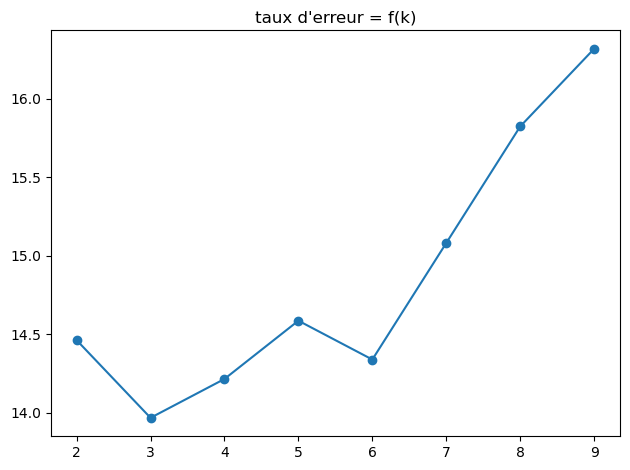

Avec un taux d'erreur de 13.97%, la valeur optimale de k-NN est 3


In [37]:
# Variable ‘nutrition_grade_fr’
# Catégorisation de la variable 'pnns_groups_2' et remplacement des catégories par une valeur numérique
data['prod_cat'] = data['pnns_groups_2'].copy(deep=True)
data['prod_cat'] = data['prod_cat'].astype("category")
data['prod_cat'].replace(data['prod_cat'].cat.categories, [i for i in range(0, len(data['prod_cat'].cat.categories))], inplace=True)

# Construction de l'échantillon pour le modèle k-NN
feature_list = ['prod_cat', 'sugars_100g', 'salt_100g', 'saturated-fat_100g', 'nutrition_grade_fr']
feature_list_x = ['prod_cat', 'sugars_100g', 'salt_100g', 'saturated-fat_100g']
data_sample = data[feature_list].dropna(how='any')

# Détermination du modèle k-NN optimum
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
k_range = 8
errors = []
xtrain, xtest, ytrain, ytest = train_test_split(data_sample[feature_list_x], data_sample['nutrition_grade_fr'], train_size=0.8)
for k in range(0, k_range):
    knn = KNeighborsClassifier(k+2)
    errors.append(100 * (1 - knn.fit(xtrain, ytrain).score(xtest, ytest)))
plt.plot(range(2, k_range+2), errors, 'o-')
plt.title("taux d'erreur = f(k)")
plt.tight_layout()
plt.show()
k = errors.index(min(errors)) + 2
print("Avec un taux d'erreur de {:.2f}%, la valeur optimale de k-NN est {:.0f}".format(errors[k-2], k))

In [38]:
# Finalisation du modèle avec l'ensemble de l'échantillon et remplacement des manquants par les prédictions
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(xtrain, ytrain)
predicted = pd.DataFrame(knn.predict(data[feature_list_x]))
predicted.index = data.index
data['predicted'] = predicted
data.nutrition_grade_fr.fillna(data.predicted, inplace=True)
data.drop('prod_cat', axis=1, inplace=True)
data.drop('predicted', axis=1, inplace=True)
#display(data[['pnns_groups_2', 'sugars_100g', 'salt_100g', 'saturated-fat_100g', 'nutrition_grade_fr']].head(200))

In [39]:
# Estimation du nutri-score à partir du nutri-grade
df = pd.DataFrame(data[['nutrition_grade_fr', 'nutrition-score-fr_100g']].copy(deep=True))
df.dropna(inplace=True)
meanScores = [round(df.loc[df['nutrition_grade_fr'] == grade, 'nutrition-score-fr_100g'].mean()) for grade in 'abcde']
for grade in 'abcde':
    mask = (data['nutrition-score-fr_100g'].isnull()) & (data['nutrition_grade_fr']==grade)
    data.loc[mask, 'nutrition-score-fr_100g'] = meanScores[ord(grade) - 97]

<a id="miss_unknown"></a>
### Traitement des manquants restants
- Variable 'palm' : les valeurs manquantes indiquent que nous ne savons pas si ces produits contiennent de l'huile de palme ou pas ; cette information est importante et doit donc être conservée.
- Variable 'stores' : ces informations ne peuvent pas être déduites de manière fiable et la quantité importante de manquants (35%, 1399) ne permet pas une recherche au cas par cas.

Pour les valeurs ci-dessus, nous fixons aux manquants la valeur '$***$unknown$***$' afin de supprimer les manquants (pour l'analyse exploratoire) tout en identifiant clairement le caractère inconnu des valeurs.

*[retour sommaire](#sommaire)*

In [40]:
# Affectation de la valeur '***unknown***' aux valeurs manquantes résiduelles
data.fillna(value='***unknown***', inplace=True)

In [41]:
# Bilan des valeurs manquantes
dataMissing['pc_new'] = 100.0 * data.isnull().sum(axis=0) / data.shape[0]
dataMissing['nb_new'] = data.isnull().sum(axis=0)
print("Manquants total sur l'ensemble des variables :",
      '{:0.0f}%'.format((100.0 * dataMissing['nb_new'].sum(axis=0)) / (data.shape[0] * data.shape[1]), "%\n"))
print("Manquants par variable :")
with pd.option_context('display.float_format', '{:0.0f}%'.format):
    display(dataMissing)

# Écriture du jeu de données résultant
data.to_csv(dossierData + "\\" + "data_notebook_01.csv", encoding='utf-8-sig', index=False)
#fct.writeDF2XLfile(data, dossierData + "\\" + "data_notebook_01")

Manquants total sur l'ensemble des variables : 0%
Manquants par variable :


,pc,nb,pc_new,nb_new
product_name,0%,12,0%,0
url,0%,0,0%,0
brands,0%,10,0%,0
stores,35%,1399,0%,0
additives_n,8%,311,0%,0
additives_tags,53%,2157,0%,0
allergens,65%,2617,0%,0
palm,8%,311,0%,0
pnns_groups_1,0%,8,0%,0
pnns_groups_2,0%,0,0%,0


<a id="conclusion"></a>
## Conclusion
Nous sommes au terme de ce premier Notebook et sauvegardons le jeu de données résultat sous le nom "data_notebook_01" (formats CSV et MS-Excel).
Pour mémoire, ce fichier dispose des caractéristiques suivantes :
- il contient les caractéristiques (variables ou features) retenues pour l'application envisagée ;
- les valeurs numériques sont vérifiées comme appartenant à un intervalle réaliste pour chaque caractéristique considérée et les erreurs corrigées, permettant de disposer de variables individuellement réalistes ;
- la cohérence entre les valeurs est vérifiée et les erreurs corrigées, permettant un jeu de données globalement cohérent ;
- les valeurs manquantes ont été traitées spécifiquement pour chaque variable afin de disposer d'un jeu de données sans aucun manquant.

*[retour sommaire](#sommaire)*